# The Explainer Notebook

### Structure of this notebook

The notebook consists of XX parts 

__________

# Part 0: Initialization

In [76]:
import requests
from bs4 import BeautifulSoup
from imdb import IMDb
import csv
import json
import pandas as pd
import numpy as np 
import regex as re
import powerlaw
import math
from collections import Counter
import heapq
import unicodedata
import networkx as nx 
import community.community_louvain as cl
import community
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from fa2 import ForceAtlas2
from pyvis.network import Network
from tabulate import tabulate
# Warning to ignore
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
color_palette_cividis = sns.color_palette("cividis", 40)
color_palette_plasma = sns.color_palette("plasma", 40)
color_palette_cividis_reversed = list(reversed(color_palette_cividis))
colorpalette = color_palette_plasma + color_palette_cividis_reversed
three_ratings_colors = [colorpalette[1],
                        colorpalette[15],
                        colorpalette[33]]
genre_colors = colorpalette[::7][0:8]
hex_colors_genre = ['#1d068d', '#6700a7', '#a51f97', '#d3516f', '#f38649', '#fdc427', '#ecd54a', '#bcae6b']
three_ratings_colors_hex = ["#290593","#ad2692","#fdb22f"]

______________

# Part 1: Data 

The data utilized for this project is obtained from various Wikipedia lists encompassing movies across different genres. Although numerous genres are available, this study will concentrate on seven specific movie genres to ensure manageability:

<div style="text-align: center;">
    <a href="https://en.wikipedia.org/wiki/Lists_of_action_films">Action</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_adventure_films">Adventure</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_comedy_films">Comedy</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_fantasy_films">Fantasy</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_horror_films">Horror</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_science_fiction_films">Science Fiction</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_thriller_films">Thriller</a>
</div>

The corresponding Wikipedia lists can be accessed through the provided links. We have extracted movie data spanning the years 2000 to 2023, encompassing essential information such as movie *title*, *director*, *cast*, *release year*, *genre*, and *country of origin*. To accomplish this, we employed `Beautiful Soup` for web scraping, enabling us to extract comprehensive tables containing movie details for each genre and year.

Additionally, for the purpose of gathering movie plots, we identified and saved the hyperlinks leading to individual movie pages. These hyperlinks were subsequently employed in Wikipedia API `requests` to retrieve and scrape the movie plots. Furthermore, we utilized the `IMDb` Module in Python to collect movie *ratings*, precise *release dates*, and *box office* information. These combined efforts yielded the following dataset:

<style>
table {
  margin: 0 auto;
}
</style>
| Attribute         | Type           | Description                                                    |
|-------------------|----------------|----------------------------------------------------------------|
| Title             | str            | Name of the movies written in the Wikipedia list.              |
| Director          | str            | Director of the movies collected from the Wikipedia list.      |
| Cast              | str            | Casts of the movies collected from the Wikipedia list.         |
| Country           | str            | The origin of the movie.                                       |
| Genre             | float          | The genre of the movie                                         |
| Year              | integer        | The release year of the movie.                                 |
| Hyperlink         | str            | The hyperlink to the Wikipedia page of the movie.              |
| Rating            | float          | The rating of the movie collected using `IMDb` Module.         |
| AirDate           | str            | The release date of the movie collected using `IMDb` Module.   |
| Plot              | str            | Plot of Movies.                                                |



In the context of network analysis, each movie will be a node, and connections between movies will be established based on the presence of common actors. This approach allows the network to illustrate the interconnections among movies in terms of shared cast members. As for the NLP part, the *plots* of the movies will be used to analyze the sentiment of the movie plots. Futhermore, the other features will be utilized in the project as attributes to the network and our analysis.

## 1.1: Data Collection of Movies

#### Data for the network analysis

In the following code the list of movies and their corresponding meta data is scraped from the seven different wikipedia pages <a href="https://en.wikipedia.org/wiki/Lists_of_action_films">Action</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_adventure_films">Adventure</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_comedy_films">Comedy</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_fantasy_films">Fantasy</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_horror_films">Horror</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_science_fiction_films">Science Fiction</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_thriller_films">Thriller</a> spanning the years 2000 to 2023. 

The data collection process employs `BeautifulSoup` and `HTML` parsing techniques to extract essential information, including tables and metadata related to the movies. Subsequently, this gathered data is stored in a Pandas DataFrame.

In [5]:
def collect_movies_artist_data(genre: str, year:str, sub_years:list) -> pd.DataFrame:
    """
    Collects movie data from Wikipedia for a specified genre, year, and subyears.

    Args:
    - genre (str): The genre of movies to collect data for.
    - year (str): The main year for which data is collected.
    - sub_years (list): A list of subyears for which data should be collected.

    Returns:
    - pd.DataFrame: A DataFrame containing movie data.

    Example usage:
    collect_movies_artist_data('horror', '2023', ['2023']) 
    """

    titles = []
    directors = []
    casts = []
    countries = []
    all_years = []
    genres = []
    link_refs = []

    # Define the URL based on the genre and year
    if genre == 'horror':
        url = f"https://en.wikipedia.org/wiki/List_of_horror_films_of_{year}"
        sub_years = [year]
    else: 
        url = f"https://en.wikipedia.org/wiki/List_of_{genre}_films_of_the_{year}"

    # Get data using BeautifulSoup and HTML
    wiki_page = requests.get(url)
    soup = BeautifulSoup(wiki_page.text, 'html.parser')

    # Find all tables in the wiki page
    all_tables = soup.find_all('table', {'class':'wikitable'})

    # Iterate through subyears and rows in tables         
    for sub_year_idx, sub_year in enumerate(sub_years):
        for row in all_tables[sub_year_idx].find_all('tr'): 
            columns = row.find_all('td')

            # Extracting the subyear of the tables that are merged and not divided into subtables. 
            if (genre == 'thriller') or (genre == 'fantasy') or (genre=='science_fiction'): 
                if (len(columns)!=0): 
                    if (re.search(r"2\d{3}\n", columns[0].text)):
                        sub_year = columns[0].text[:4]
            
            # Extract data from columns
            if len(columns) >= 4:
                if genre == 'horror' and not (sub_year == '2020' or sub_year == '2021' or sub_year == '2022' or sub_year == '2019'):
                    try: 
                        title = row.find('a').get_text(strip=True)
                    except: 
                        title = row.find('i').get_text(strip=True)
                    director = columns[0].get_text(strip=True)
                    cast_list = columns[1].get_text(strip=True)
                    country = columns[2].get_text(strip=True)
                elif genre == 'comedy' and sub_year=='2007':       
                    title = row.find('a').get_text(strip=True)
                    director = columns[0].get_text(strip=True)
                    cast_list = columns[1].get_text(strip=True)
                    country = columns[2].get_text(strip=True)
                else: 
                    title = columns[0].get_text(strip=True)
                    director = columns[1].get_text(strip=True)
                    cast_list = columns[2].get_text(strip=True)
                    country = columns[3].get_text(strip=True)

                # Get hyperlinks to movie plots
                if genre == 'horror' and not (sub_year == '2020' or sub_year == '2021' or sub_year == '2022' or sub_year == '2019'):
                    first_column = row.find('th')
                else:
                    first_column = row.find('td')

                if first_column: 
                    href_link = first_column.find('a')
                    if href_link:
                        href = href_link.get('href').replace('/wiki/', '')
                    else:
                        href = ''
                else: 
                    href = ''
        
                # Append data to lists
                titles.append(title)
                directors.append(director)
                casts.append(cast_list)
                countries.append(country)
                genres.append(genre)
                all_years.append(sub_year)
                link_refs.append(href)
    
    # Create a DataFrame from collected data
    data = {"Title": titles,
            "Director": directors,
            "Cast": casts,
            "Country": countries,
            "Genre": genres, 
            "Year": all_years, 
            "Hyperref": link_refs}
    
    df = pd.DataFrame(data)
    return df


In [6]:
# Params for the function defining the genre name, the years and the corresponding subyears for each year, which follows the structure of the corresponding wikipage.
params = {
        "thriller": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],[[]]]}, 
        "action": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]},             
        "comedy": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007"]]},
        "adventure": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022", "2023"], ["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"], ["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]}, 
        "horror": {"years": ["2020", "2021", "2022", "2010","2011","2012","2013","2014","2015","2016","2017","2018","2019", "2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"], 
                "sub_years": [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]},
        "fantasy": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [[[]],[[]],[[]]]}, 
        "science_fiction": {"years": ["2020s", "2010s", "2000s"],
                "sub_years": [[[]],[[]],[[]]]}, 
        }

# Looping over alle genres, years and subyears. 
data_movie_artist = pd.DataFrame()
for genre in params.keys():
    for years, sub_years in zip(params[genre]["years"],params[genre]["sub_years"]):
        data = collect_movies_artist_data(genre, years, sub_years)
        data_movie_artist = pd.concat([data_movie_artist, data]) 
data_movie_artist = data_movie_artist.reset_index(drop=True)

The outcome of the above code segment is a single DataFrame containing seven variables and encompassing a total of 7,456 movies.

In [8]:
data_movie_artist = pd.read_json('data_movie_artist.json', orient='table')
data_movie_artist.shape

(7456, 7)

In [9]:
data_movie_artist.head(2)

,Title,Director,Cast,Country,Genre,Year,Hyperref
0,365 Days,Barbara BiałowąsTomasz Mandes,"Anna-Maria Sieklucka,Michele Morrone, Bronisła...",Poland,thriller,2020,365_Days_(2020_film)
1,7500,Patrick Vollrath,"Joseph Gordon-Levitt,Aylin Tezel","Germany, Austria, United States",thriller,2020,7500_(film)


## 1.2 Data Cleaning of Movies

The initial step following the data collection of movies from the Wikipedia lists involves data cleaning. We identified and addressed 1,507 duplicates and also handled rows with missing data, such as missing film titles or cast information. This data cleaning step was crucial before obtaining ratings and plots since our aim was to avoid extracting unnecessary data.

Within the following code block, a series of functions inside a class named **DataCleaning** have been implemented to perform various data cleaning operations. These functions are documented to ensure that the reader can understand their purpose and functionality without needing to dive into the code.

After the code block, we will provide an explanation of the rationale behind the choice of each data cleaning operation and its significance in preparing the dataset for subsequent analysis.

In [12]:
class DataCleaning:
    def __init__(self, dataframe):
        """
        Initializes a DataCleaning instance with a given DataFrame.

        Args:
        - dataframe (pd.DataFrame): The DataFrame containing movie data to be cleaned.
        """
        self.data = dataframe
    
    def clean_text_title_column(self, text):
        """
        Cleans the 'Title' column of the DataFrame by removing unwanted characters and formatting.

        Args:
        - text (str): The text to be cleaned.

        Returns:
        - str: The cleaned text.
        """
        # Remove text within square brackets and parentheses
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\(.*?\)', '', text)
        # Replace 
        text = text.replace('!', '')
        text = text.replace('.', '')
        text = text.replace('-', '')
        return text

    def clean_text_cast_column(self, text):
        """
        Cleans the 'Casts' column of the DataFrame by removing unwanted characters and formatting.

        Args:
        - text (str): The text to be cleaned.

        Returns:
        - str: The cleaned text.
        """
        # Remove text within square brackets and parentheses
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\(.*?\)', '', text)
        # Replace 
        text = text.replace('|', '')
        text = text.replace('’', "'")
        text = text.replace('.', '')
        # Remove text within double and single quotes
        text = re.sub(r"\".*?\"", '', text)
        text = re.sub(r"'.*?'", '', text)    
        return text
    
    def clean_text_director_column(self, text):
        """
        Cleans the 'Director' column of the DataFrame by removing unwanted characters and formatting.

        Args:
        - text (str): The text to be cleaned.

        Returns:
        - str: The cleaned text.
        """
        # Remove text within square brackets and parentheses
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\(.*?\)', '', text)
        # Replace + and & with a comma
        text = text.replace('+', ',')
        text = text.replace('&', ',')
        text = text.replace('-', ' ')
        text = text.replace('—', ' ')
        text = text.replace('.', '')
        # Remove text within double and single quotes
        text = re.sub(r"\".*?\"", '', text)
        text = re.sub(r"'.*?'", '', text)    
        return text
    
    def clean_text_country_column(self, text):
        """
        Cleans the 'Country' column of the DataFrame by removing unwanted characters and formatting.

        Args:
        - text (str): The text to be cleaned.

        Returns:
        - str: The cleaned text.
        """
        # Remove text within square brackets and parentheses
        text = re.sub(r'\[.*?\]', '', text)
        # Replace 
        text = text.replace('-', ',')
        text = text.replace('<', "")
        text = text.replace('.', '')
        text = text.replace('\{', '')
        return text
    
    def clean_hyperef_column(self): 
        """
        Identifies and cleans the 'Hyperref' column of the DataFrame by retaining rows with the longest hyperlinks for each 'Title.'
        The function keeps the rows with the longest hyperlinks for each movie title and updates the DataFrame accordingly.

        Returns:
        - None
        """
        # Identifying rows with the longest 'Hyperref' for each 'Title'
        different_hyperef = self.data[self.data.duplicated(subset=['Title'], keep=False) & 
                                    self.data.groupby(['Title'])['Hyperref'].transform('nunique').ne(1)]
        max_length_indices = different_hyperef.groupby('Title')['Hyperref'].apply(lambda x: x.str.len().idxmax())
        rows_to_keep = different_hyperef.loc[max_length_indices]

        # Updating the DataFrame
        self.data = self.data[~self.data['Title'].isin(different_hyperef['Title'])]
        self.data = self.data.append(rows_to_keep).reset_index(drop=True)
    
    def add_whitespace(self, match):
        """
        Adds whitespace between concatenated words in a string where a lowercase letter is immediately followed by an uppercase letter.

        Args:
        - match (re.Match): A regular expression match object.

        Returns:
        - str: The modified string with added whitespace.
        """
        return match.group(1) + ' ' + match.group(2)

    def change_special_letters(self, text):
        """
        Changes special letters with their corresponding normal letters in a given text.

        Args:
        - text (str): The text to be modified.

        Returns:
        - str: The text with special letters replaced by normal letters.
        """
        normalized_text = unicodedata.normalize('NFD', text)
        return normalized_text.encode('ascii', 'ignore').decode('ascii')

    def clean_text(self, column, lower=True):
        """
        Cleans and standardizes the text in the specified column of the DataFrame.
        
        Args:
        - column (str): The name of the column to be cleaned.
        - lower (bool): Whether to convert the text to lowercase (default: True).

        Returns:
        - None
        """
        self.data[column] = self.data[column].str.replace(r'([a-z])([A-Z])', self.add_whitespace, regex=True) # adds space between concatenated words
        self.data[column] = self.data[column].apply(self.change_special_letters) # replace speciel letters with normal letters
        self.data[column] = self.data[column].str.strip()
        self.data[column] = self.data[column].str.replace(r'\s+', ' ', regex=True) # removes duplicated whitespaces
        if lower: 
            self.data[column] = self.data[column].str.lower() # lowercase for all besides titles and cast 
    
    def drop_rows_conditions(self):
        """
        Drop row in the DataFrame based on specific conditions. This includes:
        - empty titles and casts
        - wrong titles. 
        - duplicated movies due to occurence in year. The movies with wrong year is dropped.  

        Returns:
        - pd.DataFrame
        """
        conditions = (
            (self.data['Cast'] != '') &
            (self.data['Title'] != '') &
            (self.data['Cast'] != 'canada') & 
            (self.data['Title'] != 'citation needed') &
            (self.data['Title'] != 'Kevin VanHook') &
            (self.data['Title'] != 'J.T. Petty') &
            (self.data['Title'] != 'Reggie Bannister michael hoffman jr'))
        
        self.data = self.data[conditions].reset_index(drop=True)

        # These titles with the corresponding director is wrong entries. 
        incorrect_entries = [
            ('Hot Tub Time Machine', 'sean anders john morris'),
            ('The Matrix Reloaded', 'the wachowskis nb 9'),
            ('The Matrix Revolutions', 'the wachowskis nb 10'),
            ('Jade Warrior', 'tommi eronen'),
            ('The Bleeding', 'charles picerni'),
            ('The Huntsman: Winter\'s War', 'frank darabont'),
            ('Stowaway', 'adam lipsius'), 
            ('World War Z', 'chris la martina')]
        
        for title, wrong_director in incorrect_entries:
            idx_to_remove = self.data[(self.data['Title'] == title) & 
                                        (self.data['Director'].str.lower() == wrong_director.lower())].index
            self.data = self.data.drop(idx_to_remove)

        # Define movies to remove due to wrong year
        movies_to_remove_year = {
                        'Run Sweetheart Run': "2022",
                        'The Black Phone': "2022",
                        'Bhool Bhulaiyaa 2': "2021",
                        'Apartment 143': "2012",
                        'Underworld: Blood Wars': "2017", 
                        'Bloody Bloody Bible Camp': '2012', 
                        'Flash Point': '2006', 
                        'Kingsman: The Secret Service': '2015', 
                        'Battle Royale': '2001',
                        'Smokin\' Aces': '2007',
                        'Tokyo Gore Police': '2007',
                        'Sky Captain and the World of Tomorrow': '2003',
                        'Decoys': '2003', 
                        'How to Talk to Girls at Parties': '2018',
                        'Monsters: Dark Continent': '2014', 
                        'Kingsman: The Secret Service': '2015', 
                        'Donkey Punch': '2007', 
                        'Manborg': '2010', 
                        'Army of Frankensteins': '2014',
                        'Growth':'2009', 
                        'Universal Soldier: Regeneration': '2010',
                        'Army of Frankensteins': '2014',
                        'BloodRayne': '2006',
                        '300': '2007', 
                        'M3GAN': '2023', 
                        'Excision': '2008', 
                        'Color Out of Space': '2020',
                        'Faust: Love of the Damned': '2001',
                        'Bunshinsaba': '2012',
                        'An American Haunting': '2006',
                        'The Gingerdead Man': '2006', 
                        'Big Bad Wolf': '2007',
                        'Hurt': '2008',
                        'Strigoi': '2009',
                        'Seventh Son': '2015', 
                        'The Shape of Water': '2018', 
                        'Beowulf & Grendel': '2006', 
                        'Dirty Deeds': '2002', 
                        'Beowulf Grendel': '2006'}
        
        movies_to_remove_hyperref = {'The Beach': 'The_Beach_(2000_film)', 
                                        'Edge of Tomorrow': 'Edge_of_Tomorrow_(film)', 
                                        'The Medallion': 'The_Medallion_(film)'}
            
        # Create a mask for all movies to be removed at once
        mask_year = self.data.apply(lambda x: (x['Title'], x['Year']) in movies_to_remove_year.items(), axis=1)
        self.data = self.data[~mask_year].reset_index(drop=True)

        mask_hyperref = self.data.apply(lambda x: (x['Title'], x['Hyperref']) in movies_to_remove_hyperref.items(), axis=1)
        self.data = self.data[~mask_hyperref].reset_index(drop=True)
        
    def consolidate_directors(self):
        """
        Consolidates director names within the same movie title.

        This method identifies cases where multiple directors are listed for the same movie title
        and consolidates them into a single director name. It selects the longest director name
        and checks if any part of a shorter name is present in the longest name. If so, it retains
        the longest name.

        Returns:
        - None
        """
        
        def inner_consolidate_directors(group):
                # Find the longest director name
            longest_director = max(group, key=len)
            # Split the longest name into a set of words for easy comparison
            longest_director_words = set(longest_director.lower().split())

            # Function to check if any part of a shorter name is in the longest name
            def is_subname_any(shorter, longer_words):
                shorter_words = set(shorter.lower().split())
                # Check if any word from the shorter name is in the longer name
                return any(word in longer_words for word in shorter_words)

            # Consolidate director names
            group = [longest_director if is_subname_any(d, longest_director_words) else d for d in group]
            return group
        self.data['Director'] = self.data.groupby('Title')['Director'].transform(inner_consolidate_directors)
    
    def differentiate_same_title(self):
        """
        Differentiates movie titles with the same name but different directors.

        This method distinguishes movie titles that share the same name but have different directors.
        It appends the director's name to the title to create unique titles for these cases.

        Returns:
        - None
        """
        different_directors = self.data[self.data.duplicated(subset=['Title'], keep=False) &
                                        self.data.groupby(['Title'])['Director'].transform('nunique').ne(1)]
        for index, row in different_directors.iterrows():
            self.data.loc[index, 'Title'] = row['Title'] + ' ' + row['Director']
        self.data = self.data.reset_index(drop=True)
    
    def clean_cast(self): 
        """
        Cleans the 'Cast' column by retaining rows with the longest cast lists for each 'Title.'

        This method identifies rows with the same movie title but varying cast lists and retains
        rows with the longest cast lists. It updates the DataFrame accordingly.

        Returns:
        - None
        """
        # Identifying rows with the longest 'Cast' for each 'Title'
        different_cast = self.data[self.data.duplicated(subset=['Title'], keep=False) & 
                                self.data.groupby(['Title'])['Cast'].transform('nunique').ne(1)]
        max_length_indices = different_cast.groupby('Title')['Cast'].apply(lambda x: x.str.len().idxmax())
        rows_to_keep = different_cast.loc[max_length_indices]

        # Updating the DataFrame
        self.data = self.data[~self.data['Title'].isin(different_cast['Title'])]
        self.data = self.data.append(rows_to_keep).reset_index(drop=True)

        # Keep only the five first names
        self.data['Cast'] = self.data['Cast'].str.split(',').str[:5].str.join(',')
    
    def data_clean_genres(self):
        """
        Cleans and consolidates movie genres based on predefined genre combinations.

        This method cleans and consolidates the movie genres by mapping specific genre combinations to
        their corresponding new names. It groups movies by title, applies a set to the 'Genre' column,
        converts the set of genres to a sorted tuple, and maps the genre combinations to the desired
        genre string or 'Mix.' Finally, it updates the 'Genre' column in the DataFrame.

        Returns:
        - None
        """
        # Define your specific genre combinations and their new names
        genre_combinations = {
                            ('horror',): 'Horror',
                            ('comedy',): 'Comedy',
                            ('action',): 'Action',
                            ('thriller',): 'Thriller',
                            ('science_fiction',): 'Science Fiction',
                            ('adventure',): 'Adventure',
                            ('fantasy',): 'Fantasy',
                            ('action', 'science_fiction'): 'Science Fiction',
                            ('action', 'thriller'): 'Action',
                            ('action', 'comedy'): 'Action',
                            ('adventure', 'fantasy'): 'Fantasy',
                            ('comedy', 'horror'): 'Horror',
                            ('comedy', 'fantasy'): 'Fantasy',
                            ('horror', 'science_fiction'): 'Science Fiction',
                            ('horror', 'thriller'): 'Horror',
                            ('adventure', 'science_fiction'): 'Science Fiction',
                            ('action', 'adventure'): 'Action',
                            ('action', 'adventure', 'science_fiction'): 'Science Fiction',
                            ('adventure', 'comedy'): 'Comedy'}

        # Group by title and apply a set to the 'Genre' column
        title_genres = self.data.groupby('Title')['Genre'].apply(set).reset_index()

        # Convert the set of genres to a sorted tuple
        title_genres['genre_combination'] = title_genres['Genre'].apply(lambda x: tuple(sorted(x)))

        # Map the genre combinations to the desired string or 'other'
        title_genres['Genre'] = title_genres['genre_combination'].apply(
            lambda genre_tuple: genre_combinations.get(genre_tuple, 'Mix'))

        # Map titles to their new genre
        title_to_new_genre = pd.Series(title_genres['Genre'].values, index=title_genres['Title']).to_dict()
        self.data['Genre'] = self.data['Title'].map(title_to_new_genre)
    
    def unique_country_combinations(self):
        """
        Identifies unique country combinations and maps them to a single country name.

        This method iterates through the DataFrame, identifies unique country combinations
        by sorting and joining country names, and maps them to a single country name. It updates
        the 'Country' column in the DataFrame accordingly.

        Returns:
        - None
        """
        unique_combinations = {}
        unique_country_combinations = []
        for index, row in self.data.iterrows():
            country_combination = ' '.join(sorted(row['Country'].split()))
            if country_combination not in unique_combinations:
                unique_combinations[country_combination] = row['Country']
                unique_country_combinations.append(country_combination)
            else:
                first_occurrence_index = unique_country_combinations.index(country_combination)
                unique_country_combinations.append(unique_country_combinations[first_occurrence_index])
        self.data['Country'] = [unique_combinations[combination] for combination in unique_country_combinations]

    def map_country_to_continent(self):
        """
        Maps country names to their corresponding continents based on predefined mappings.

        This method maps country names in the 'Country' column of the DataFrame to their corresponding
        continents based on predefined mappings. It also handles cases where country counts are low
        by grouping them as 'mix.' It updates the 'Country' column in the DataFrame with continent names.

        Returns:
        - None
        """

        country_counts = self.data['Country'].value_counts()
        continent_mapping = {
            'north nmerica': ['united states', 'canada', 'mexico', 'honduras'],
            'united states': ['usa', 'american'],
            'asia': ['indonesia', 'japan', 'taiwan', 'hong kong', 'china', 'south korea', 'myanmar', 'india', 'israel', 'jordan', 'qatar', 'japan', 'thailand', 'singapore', 
                    'malaysia', 'kazakhstan', 'vietnam', 'pakistan', 'philippines', 'bangladesh', 'bhutan', 'cambodia', 'laos', 'brunei', 'timor-leste', 'mongolia', 
                    'tajikistan', 'kyrgyzstan', 'turkmenistan', 'uzbekistan', 'kazakhstan', 'nepal'],
            'europe': ['italy', 'germany', 'france', 'norway', 'sweden', 'ireland', 'new zealand', 'netherlands', 'denmark', 'united kingdom', 'spain', 'belgium', 'poland', 
                    'czech republic', 'russia', 'austria', 'switzerland', 'iceland', 'greece', 'romania', 'serbia', 'turkey', 'luxembourg', 'portugal', 'malta', 
                    'bulgaria', 'ireland', 'croatia', 'slovenia', 'slovakia', 'latvia', 'estonia', 'hungary', 'belarus', 'lithuania', 'macedonia', 'monaco', 
                        'armenia', 'kazakhstan', 'poland', 'estonia', 'hungary', 'lithuania', 'slovenia', 'slovakia', 'estonia'],
            'south america': ['argentina', 'chile', 'peru', 'brazil', 'colombia', 'ecuador', 'french guiana', 'trinidad and tobago', 'venezuela', 'guyana', 'suriname']}

        def inner_map_country_to_continent(country):
            if country_counts.get(country, 0) < 45:
                for continent, countries in continent_mapping.items():
                    if country in countries:
                        return continent
                return "mix"
            return country
        self.data['Country'] = self.data['Country'].apply(inner_map_country_to_continent)
        
    def clean_country(self): 
        """
        Cleans the 'Country' column in the DataFrame by retaining rows with the longest country name for each title.

        This method identifies rows with the longest 'Country' name for each 'Title' and retains them while removing
        other rows with the same 'Title.' It also handles cases where the country is labeled as 'other' and retains them
        only if there are no other countries associated with the same 'Title.' The 'Country' column is updated accordingly.

        Returns:
        - None
        """

        # Identifying rows with the longest 'Country' for each 'Title'
        different_country = self.data[self.data.duplicated(subset=['Title'], keep=False) & 
                                        self.data.groupby(['Title'])['Country'].transform('nunique').ne(1)]
        
        # Remove rows with 'other' country, except those identified above
        only_other_country = self.data.groupby('Title').filter(lambda x: (x['Country'] == 'other').all())
        different_country = different_country[~((different_country['Country'] == 'other') & 
                                                ~different_country['Title'].isin(only_other_country['Title']))]
        
        # Identify the row with the longest country name for each title
        max_length_indices = different_country.groupby('Title')['Country'].apply(lambda x: x.str.len().idxmax())
        rows_to_keep = different_country.loc[max_length_indices]

        # First, remove all rows with the titles that have duplicates in different_country
        self.data = self.data[~self.data['Title'].isin(different_country['Title'])]
        
        # Then, append the rows to keep to the filtered DataFrame
        self.data = self.data.append(rows_to_keep).reset_index(drop=True)

    def categorize_year(self, year):
        """
        Categorizes a year into decades based on predefined criteria.

        This method takes a year as input and categorizes it into decades based on predefined criteria.
        It returns the corresponding decade label ('00-09,' '10-19,' or '20-29').

        Args:
        - year (str): A year to be categorized.

        Returns:
        - str: The categorized decade label.
        """

        if "2000" <= year <= "2009":
            return "00-09"
        elif "2010" <= year <= "2019":
            return "10-19"
        else:
            return "20-29"

    def data_cleaning(self): 
        """
        Performs comprehensive data cleaning on the DataFrame.

        This method executes a series of data cleaning operations on the DataFrame, including:
        - Cleaning the 'Title,' 'Cast,' 'Director,' 'Genre,' 'Country,' and 'Hyperref' columns.
        - Consolidating director names, differentiating titles with the same name but different directors, and cleaning cast entries.
        - Categorizing movie genres based on predefined combinations.
        - Handling country entries by ensuring the longest name is retained for each title.
        - Mapping countries to continents based on predefined mappings.
        - Categorizing years into decades.
        - Removing duplicate rows, keeping the first occurrence.

        Returns:
        - None
        """
        self.data['Title'] = self.data['Title'].apply(self.clean_text_title_column)
        self.clean_text('Title', lower = False)
        
        self.data['Cast'] = self.data['Cast'].apply(self.clean_text_cast_column)
        self.clean_text('Cast')
        self.drop_rows_conditions()

        self.data['Director'] = self.data['Director'].apply(self.clean_text_director_column)
        self.clean_text('Director')
        self.consolidate_directors()
        self.differentiate_same_title()

        self.clean_cast()

        self.clean_text('Genre')
        self.data_clean_genres()
        
        self.data['Country'] = self.data['Country'].apply(self.clean_text_country_column)
        self.clean_text('Country')
        self.unique_country_combinations()
        self.map_country_to_continent()
        self.clean_country()

        self.clean_hyperef_column()

        self.data = self.data.drop_duplicates(keep='first')

        self.data['Decade'] = self.data['Year'].apply(self.categorize_year)

| Operation                                   | Explanation                                                                                                                    |
|--------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------|
| Clean Text Columns                         | The text columns, such as 'Title,' 'Cast,' 'Director,' 'Genre,' and 'Country,' are cleaned to ensure that names and text are standardized. This helps in matching similar names and ensures consistency in the data. |
| Drop Incorrect Columns                     | Some columns with incorrect or unreliable information are dropped from the dataset to prevent misleading data from affecting subsequent analysis.         |
| Handle Duplicate Movies                    | Movies that appear multiple times with the same or different years are reviewed, and the correct year is retained while removing duplicates.        |
| Consolidate Directors                      | Movies with multiple directors are consolidated to retain all director names for a movie. This ensures that the dataset maintains all available director information.     |
| Genre Mapping                               | Movies with different genres, due to appearing in multiple Wikipedia pages, are handled by mapping genre combinations to standardized genres. The handling of genre combinations, as shown in the table, involved a thoughtful approach. Genres like *Fantasy* and *Science Fiction* were retained when a movie appeared in both genres, as these genres possess distinct characteristics. For other genre combinations such as *comedy* and *horror* or *horror* and *thriller*, a sampling approach was used to determine the primary genre for each movie. This decision was based on plot analysis and genre mentions in external sources. Due to resource constraints, this method was applied selectively, acknowledging the potential introduction of bias to the data. |
| Country Mapping                             | To reduce the number of unique country entries, countries with fewer than 40 entries are mapped to the continent they belong to, enhancing data clarity and reducing redundancy.    |
| Create Decade Column                        | A new column 'Decade' is added to categorize movies by the decade they belong to, simplifying temporal analysis.                |
| Remove Duplicate Rows                      | After all cleaning operations, duplicate rows are removed, resulting in a dataset with 5,778 unique movies.                    |


These data cleaning operations were executed to ensure that the dataset is accurate, consistent, and well-prepared for subsequent analysis.

In [20]:
data_cleaner = DataCleaning(data_movie_artist)
data_cleaner.data_cleaning()
df_movies = data_cleaner.data

In [27]:
df_movies = pd.read_json('df_movies.json', orient='table')

(5778, 8)

In [28]:
df_movies.head(2)

,Title,Director,Cast,Country,Genre,Year,Hyperref,Decade
0,365 Days,barbara biaowas tomasz mandes,"anna-maria sieklucka,michele morrone, bronisaw...",europe,Thriller,2020,365_Days_(2020_film),20-29
1,7500,patrick vollrath,"joseph gordon-levitt,aylin tezel",mix,Action,2020,7500_(film),20-29


## 1.3 Collect Ratings

After obtaining a cleaned movie DataFrame containing unique titles, we proceed to retrieve movie ratings using the `IMDb` Python module. Movie ratings are represented as floating-point values within the range [0, 10]. Subsequently, we introduce a new column named RatingLabel, which categorizes movies into one of three categories: *Low*, *Moderate*, or *High*. The classification boundaries for these categories are determined based on the 25th and 75th percentiles of the ratings distribution. Futhermore, some movies were not found in the IMDb module, and as a result, these movies were excluded from the dataset during the rating retrieval process.

In [18]:
# Initialize the IMDb object
ia = IMDb()

# Function to get movie rating
def get_movie_rating(title):
    """
    Get the IMDb rating for a given movie title.

    Args:
        title (str): The title of the movie.

    Returns:
        float: The IMDb rating of the movie, or None if not found.
    """
    try:
        movie = ia.search_movie(title)[0] 
        ia.update(movie)
        return movie.data['rating']
    except Exception as e:
        return None

def get_ratings(data):
    """
    Calculate movie rating labels based on IMDb ratings.

    Args:
        data (DataFrame): The input DataFrame containing movie data.

    Returns:
        DataFrame: A new DataFrame with added rating labels ('Low', 'Moderate', 'High').
    """
    # Read the ratings DataFrame from a JSON file
    ratings_df = pd.read_json('Ratings_df.json', orient='table')

    # Merge the input data with the ratings DataFrame on the 'Title' column
    data_ratings = pd.merge(data, ratings_df, on='Title', how='inner')

    # Drop rows with missing values
    data_ratings = data_ratings.dropna()
    
    # Reset the index
    data_ratings = data_ratings.reset_index(drop=True)

    # Calculate rating labels based on percentiles
    percentile_25 = data_ratings['Rating'].quantile(0.25) 
    percentile_75 = data_ratings['Rating'].quantile(0.75)
    
    def label_rating(row):
        if row < percentile_25:
            return 'Low'
        elif row >= percentile_75:
            return 'High'
        else:
            return 'Moderate'
        
    # Add a new column 'RatingLabel' to the DataFrame
    data_ratings['RatingLabel'] = data_ratings['Rating'].apply(label_rating)
    
    return data_ratings


In [ ]:
# Add a new column to the DataFrame with the ratings
df_movies['Rating'] = df_movies['Title'].apply(get_movie_rating)
df_movies = get_ratings(df_movies)

In [31]:
df_movies = pd.read_json('df_movies_ratings.json', orient='table')
df_movies.shape

(5247, 12)

In [32]:
df_movies.head(2)

,Title,Director,Cast,Country,Genre,Year,Hyperref,Decade,Rating,RatingLabel,DirectorIMDb,AirDate
0,365 Days,barbara biaowas tomasz mandes,"anna-maria sieklucka,michele morrone, bronisaw...",europe,Thriller,2020,365_Days_(2020_film),20-29,3.3,Low,"[Barbara Bialowas, Tomasz Mandes]",07 Feb 2020
1,7500,patrick vollrath,"joseph gordon-levitt,aylin tezel",mix,Action,2020,7500_(film),20-29,6.3,Moderate,[Patrick Vollrath],26 Dec 2019


## 1.4: Data Collection of Plots 

# JOJO din collection and cleaning part her tak

_______________

# Part 2: Basic Statistics

This section will give an introduction to the data set.

**Rating distribution:** 

To begin with the rating distribution will be presented along with the limits for determining the threshold for the rating categories *Low*, *Moderate* and *High*. It is important to look at the distribution in order to conclude whether or not the data is dominated by higher or lower rated movies. 

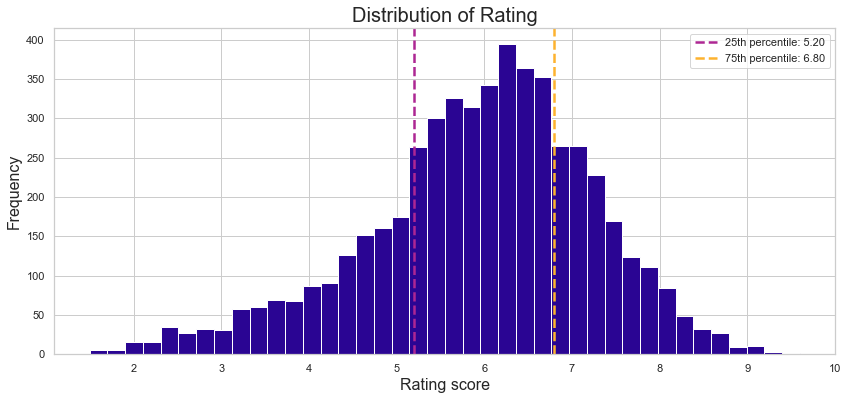

In [92]:
# Plot the histogram using matplotlib
plt.figure(figsize=(14,6))
plt.hist(list(df_movies['Rating'].values), bins=40, edgecolor='white', color=three_ratings_colors[0])
plt.xlabel('Rating score', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title('Distribution of Rating', fontsize=20)

# Add vertical lines for mean and median
percentile_25 = np.percentile(list(df_movies['Rating'].values), 25)
percentile_75 = np.percentile(list(df_movies['Rating'].values), 75)
plt.axvline(percentile_25, color=three_ratings_colors[1], linestyle="dashed", linewidth=2.5, label=f"25th percentile: {percentile_25:.2f}")
plt.axvline(percentile_75, color=three_ratings_colors[2], linestyle="dashed", linewidth=2.5, label=f"75th percentile: {percentile_75:.2f}")
    
# Add a legend
plt.legend()
plt.show()

The shown plot illustrates that the distribution of movie rating scores follows a normal distribution, thereby indicating the presence of a statistically representative dataset in terms of rating scores. Furthermore, the 25th and 75th percentiles are shown, serving as the thresholds employed in determining the categorization labelslow*, *moderate* and *high* for the movies.

- NB: The following plots are plotted using the functions from the class Plots, which can be seen under the section Functions.

Now let us see the distribution of the rating labels. 
- NB the following plots uses functions from the Class Plots which can be found in the Functions section.

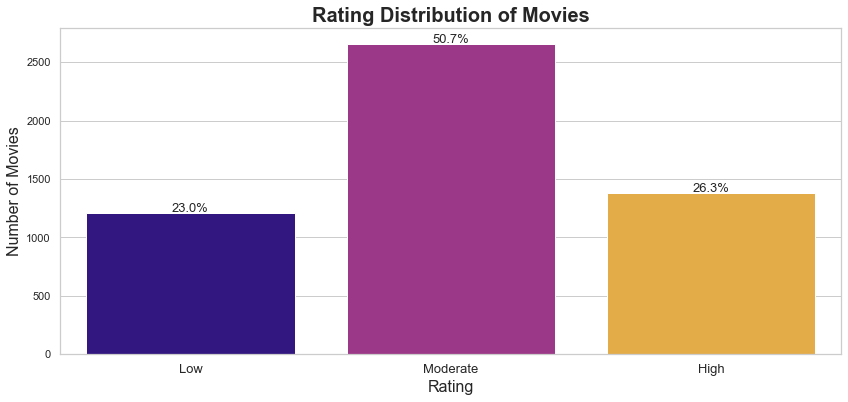

In [90]:
rating_counts = df_movies['RatingLabel'].value_counts()
rating_counts = rating_counts.reset_index()
rating_counts.columns = ['RatingLabel', 'Count']
ordered_labels = ['Low', 'Moderate', 'High']
rating_counts['RatingLabel'] = pd.Categorical(rating_counts['RatingLabel'], categories=ordered_labels, ordered=True)
rating_counts = rating_counts.sort_values('RatingLabel')
plots = Plots()
plots.plot_bar(x = 'RatingLabel', y = 'Count', data = rating_counts, title = 'Rating Distribution of Movies', 
         xlabel= 'Rating', ylabel= 'Number of Movies', figsize=(14,6), 
         color_palette=three_ratings_colors)

From the above plot it can be seen that the *Moderate* category is the largest rating in the data, while the *High* and *Low* categories are almost equal, with a small different on 3%.
- NB this plot *is not used* in the paper.  

**Genre Distribution**

Now we consider genre distribution of the movies. It is important to look at the distribution in order to conclude whether or not the data is dominated by a genre. 

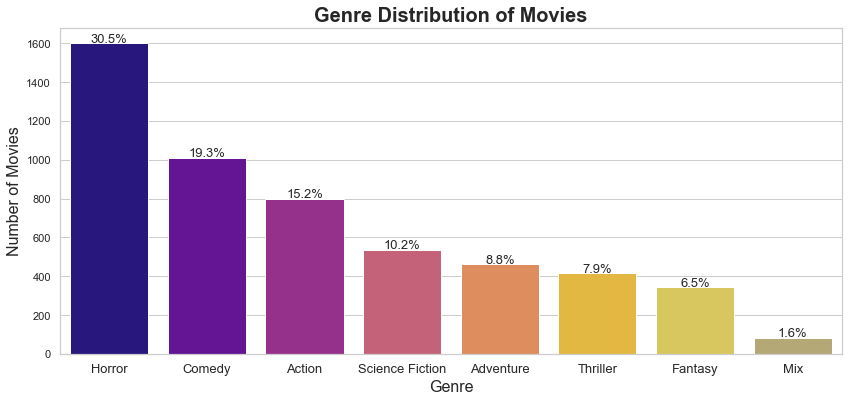

In [89]:
genre_counts = df_movies['Genre'].value_counts()
genre_counts = genre_counts.reset_index()
genre_counts.columns = ['Genre', 'Count']
plots = Plots()
plots.plot_bar(x ='Genre', y='Count', data=genre_counts, title='Genre Distribution of Movies', 
         xlabel='Genre', ylabel = 'Number of Movies', figsize=(14,6), color_palette=genre_colors)

From the above plot it can be seen that the genres **Horror** and **Comedy** is the largest genres in the data. Notice also, that we have a movies with mixed genres, however, this only includes 1.6 % of the movies in the data set. 

**Movies over time**

As we have collected data from 2000 to 2023, it is interesting to see the number of movies in each year. 

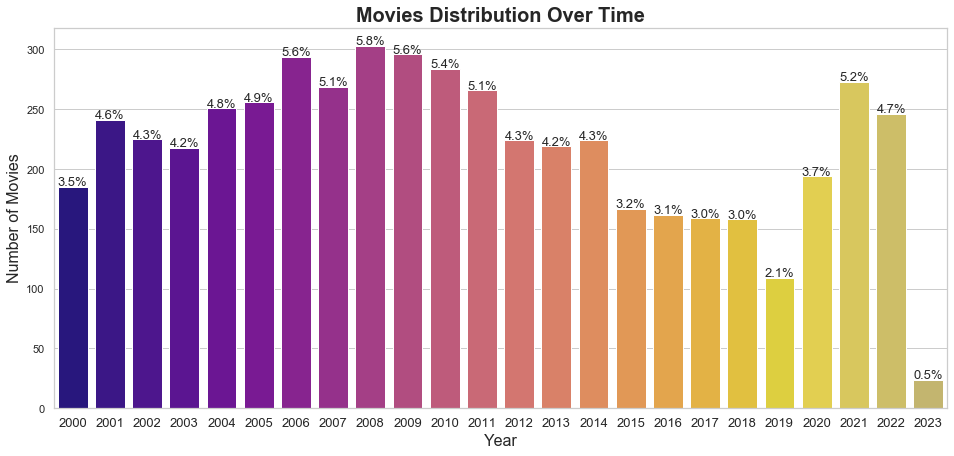

In [87]:
df_movies['Year'] = pd.to_numeric(df_movies['Year'], errors='coerce')
movies_per_year = df_movies.groupby('Year').size()
movies_per_year = movies_per_year.reset_index()
movies_per_year.columns = ['Year', 'Number of Movies']
plots = Plots()
plots.plot_bar(x ='Year', y='Number of Movies', data=movies_per_year, title='Movies Distribution Over Time', 
         xlabel='Year', ylabel = 'Number of Movies', figsize=(16,7), color_palette=colorpalette[::2])

It's noteworthy that the distribution of the number of movies over time appears to be relatively uniform. However, it's evident that the count of movies in 2023 is notably lower. This discrepancy is attributed to the fact that the Wikipedia list of 2023 encompasses also upcoming movies in 2023, from which we didn't extract data due to the unavailability of ratings, making it impossible to include the year 2023 in all the Wikipedia lists we extracted. We only included those where 2023 upcoming movies where distinguished in a separated table.

**Country Distribution**

Now we consider the distribution of origin of the movies. 

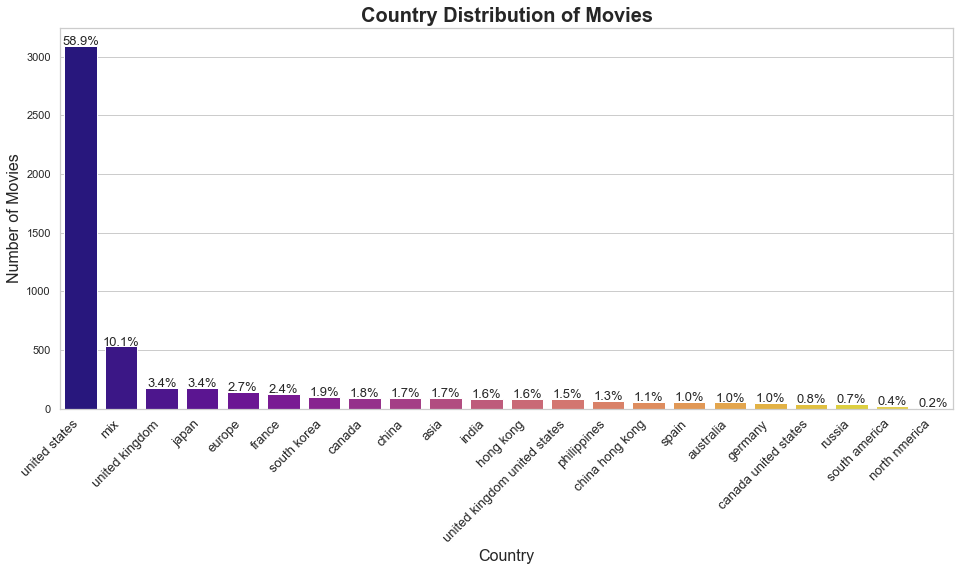

In [91]:
country_counts = df_movies['Country'].value_counts()
country_counts = country_counts.reset_index()
country_counts.columns = ['Country', 'Count']
plots = Plots()
plots.plot_bar(x ='Country', y='Count', data=country_counts, title='Country Distribution of Movies', 
         xlabel='Country', ylabel = 'Number of Movies', figsize=(16,7), color_palette=colorpalette[::2], rotation=True)

It's evident that the movies in our dataset are predominantly comprised of American films.

> Given that our research aims to explore the factors contributing to a movie's success, with movie ratings serving as indicator of success, we are interested in examining the distribution of casts and directors within the top-rated movies.

**Casts, directors and decades of top 100 rated movies**: 


In [96]:
top_100_rated_movies = df_movies.nlargest(100, 'Rating')

In [107]:
# Split the 'Cast' column on commas and stack the resulting Series
cast_series = top_100_rated_movies['Cast'].str.split(',').explode()
# Value count on the split names
cast_value_counts = cast_series.value_counts().reset_index().rename(columns={'index': 'Actor', 'Cast': 'Count'})
print(tabulate(cast_value_counts, headers='keys', tablefmt='pretty'))

+-----+------------------------+-------+
|     |         Actor          | Count |
+-----+------------------------+-------+
|  0  |   scarlett johansson   |   3   |
|  1  |    viggo mortensen     |   3   |
|  2  |     ian mc kellen      |   3   |
|  3  |      elijah wood       |   3   |
|  4  |     christian bale     |   3   |
|  5  |    carrie-anne moss    |   3   |
|  6  |    robert downey jr    |   2   |
|  7  |   leonardo di caprio   |   2   |
|  8  |     jonathan brugh     |   2   |
|  9  |     michael caine      |   2   |
| 10  |   laurence fishburne   |   2   |
| 11  |      keanu reeves      |   2   |
| 12  |     anne hathaway      |   2   |
| 13  |      prakash raj       |   2   |
| 14  |      chris evans       |   2   |
| 15  |     mara nicolescu     |   1   |
| 16  |    gheorghe dinica     |   1   |
| 17  |      devin ratray      |   1   |
| 18  |     george clooney     |   1   |
| 19  |    paolo bonacelli     |   1   |
| 20  |     thekla reuten      |   1   |
| 21  |       gu

It is evident from the table that the actors in the top rated movies are well-known actors. 

In [116]:
# Split the 'director' column on commas and stack the resulting Series
director_series = top_100_rated_movies['Director'].str.split(',').explode()
# Value count on the split names
director_value_counts = director_series.value_counts().reset_index().rename(columns={'index': 'Director', 'Director': 'Count'})
print(tabulate(director_value_counts, headers='keys', tablefmt='pretty'))

+----+--------------------------------+-------+
|    |            Director            | Count |
+----+--------------------------------+-------+
| 0  |       christopher nolan        |   6   |
| 1  |         peter jackson          |   3   |
| 2  |         taika waititi          |   2   |
| 3  |       william brent bell       |   2   |
| 4  |         the wachowskis         |   2   |
| 5  |        jemaine clement         |   2   |
| 6  |          ridley scott          |   2   |
| 7  |        taneli mustonen         |   1   |
| 8  |         anton corbijn          |   1   |
| 9  |      chatrichalerm yukol       |   1   |
| 10 |         wenn v deramas         |   1   |
| 11 |          nae caranfil          |   1   |
| 12 |           doug ellin           |   1   |
| 13 |     franziska meyer price      |   1   |
| 14 |             badri              |   1   |
| 15 |         park chan wook         |   1   |
| 16 |       steven soderbergh        |   1   |
| 17 |          adam fields           | 

It is evident from the table that the directors in the top rated movies are well-known directors, which movies have grossed a high sum of box office.  

In [121]:
# Split the decade column on commas and stack the resulting Series
decade_series = top_100_rated_movies['Decade'].str.split(',').explode()
# Value count on the split names
decade_value_counts = decade_series.value_counts().reset_index().rename(columns={'index': 'Decade', 'Decade': 'Count'})
print(tabulate(decade_value_counts, headers='keys', tablefmt='pretty'))

+---+--------+-------+
|   | Decade | Count |
+---+--------+-------+
| 0 | 00-09  |  49   |
| 1 | 10-19  |  41   |
| 2 | 20-29  |  10   |
+---+--------+-------+


______________

# Part 3: Network Analysis

In this part of the project, we will establish and conduct an analysis of a network. The network will be constructed with nodes representing individual movies and edges represents connections between these movies. Movies will be linked in this network if they share at least one actor in their respective casts. Consequently, the initial network structure is inherently undirected.

Subsequently, we will extract the largest Giant Connected Component (GCC) from the initial network. This GCC network will serve as the foundation for our subsequent analytical investigations and research.


Our initial step will involve the creation of a dictionary containing all unique movies. For each movie within this dictionary, we will systematically document the connected movies and the respective casts that link these two movies together.

In [122]:
def connected_movies_and_cast(df_movies: pd.DataFrame):
    # Create a dictionary to map each movie to its cast
    movie_cast_map = {}
    for index, row in df_movies.iterrows():
        cast_list = [cast.strip() for cast in row['Cast'].split(',')]
        movie_cast_map[row['Title']] = set(cast_list)

    # Create the desired dictionary structure
    connected_movies = {}
    for movie, casts in movie_cast_map.items():
        connections = {}
        for other_movie, other_casts in movie_cast_map.items():
            if movie != other_movie:
                shared_casts = casts.intersection(other_casts)
                if shared_casts:
                    connections[other_movie] = list(shared_casts)
        # Include the movie even if it has no connections
        connected_movies[movie] = connections
    return connected_movies

connected_movies = connected_movies_and_cast(df_movies)

In [35]:
with open('connected_movies_and_artists.json', 'r') as file:
    connected_movies = json.load(file)

In [128]:
keys_to_extract = list(connected_movies.keys())[:3]
values_to_extract = [connected_movies[key] for key in keys_to_extract]
values_to_extract

[{'365 Days: This Day': ['michele morrone',
   'anna-maria sieklucka',
   'magdalena lamparska']},
 {'Looper': ['joseph gordon-levitt'],
  'Premium Rush': ['joseph gordon-levitt'],
  'Sin City: A Dame to Kill For': ['joseph gordon-levitt'],
  'Hesher': ['joseph gordon-levitt'],
  '50/50': ['joseph gordon-levitt'],
  'Don Jon': ['joseph gordon-levitt'],
  'The Walk': ['joseph gordon-levitt'],
  'GI Joe: The Rise of Cobra': ['joseph gordon-levitt'],
  'Inception': ['joseph gordon-levitt'],
  'Project Power': ['joseph gordon-levitt'],
  'Treasure Planet': ['joseph gordon-levitt']},
 {'No Sudden Move': ['amy seimetz'],
  'Sabotage': ['joe manganiello'],
  'The Spine of Night': ['joe manganiello'],
  'Pet Sematary': ['amy seimetz'],
  'Rampage': ['joe manganiello'],
  'Upstream Color': ['amy seimetz']}]

## 3.1 Network creation

To begin with the network is created by creating a undirected graph in which a node is added for each movie. Attributes are added to the nodes from the dataframe. Hereafter the edges are set after the connected movies for each movie.

In [36]:
# Create undirected Graph
G_movies = nx.Graph()

# Adding nodes
movies_nodes = list(connected_movies.keys())
G_movies.add_nodes_from(movies_nodes)

node_attr = df_movies[['Title','Director','Cast','Country','Genre', 'RatingLabel',
                'Year', 'Decade']].set_index('Title').to_dict('index') # Creating a dictionary with the characters and their attributes

nx.set_node_attributes(G_movies, node_attr) #Adding attributes to the graph

for movie in connected_movies.keys():
    for connected_movie in connected_movies[movie]: 
        attribute_value = connected_movies[movie][connected_movie]
        G_movies.add_edges_from([(movie, connected_movie)], attribute_name=attribute_value)


In [37]:
print("The network consist of: ", G_movies.number_of_nodes(), " nodes (Movies)")
print("The network consist of: ", G_movies.number_of_edges(), " edges")

The network consist of:  5247  nodes (Movies)
The network consist of:  29813  edges


**Extract largest Giant Connected Component (GCC)**

In [38]:
#Extracting the largest component
connected_components = nx.connected_components(G_movies)
# Finding the largest connected component
largest_cc = max(connected_components, key=len)
# Creating a subgraph for the largest connected component
G_largest_cc = G_movies.subgraph(largest_cc).copy()

In [39]:
print("The largest connected component network consist of: ", G_largest_cc.number_of_nodes(), " nodes (Movies)")
print("The largest connected component network consist of: ", G_largest_cc.number_of_edges(), " edges")

The largest connected component network consist of:  3874  nodes (Movies)
The largest connected component network consist of:  29444  edges


In [44]:
# New dataframe which only consist of movies in the largest CC network:
movies_largest_cc = list(G_largest_cc.nodes())
df_largest_cc = df_movies[df_movies['Title'].isin(movies_largest_cc)]

## 3.2 Visualization of the Network JOJO

## 3.3 Degree Distribution & Eigenvector Centrality

In [77]:
degree_sequence = [d for _, d in G_largest_cc.degree()]
fit = powerlaw.Fit(degree_sequence)
exponent = fit.power_law.alpha
print("Exponent of the degree distribution:", exponent)

Calculating best minimal value for power law fit
Exponent of the degree distribution: 8.913367077125251


$\gamma > 3$ indicates that this falls into the random network regime. This makes the network hard to distinguish from a random network.

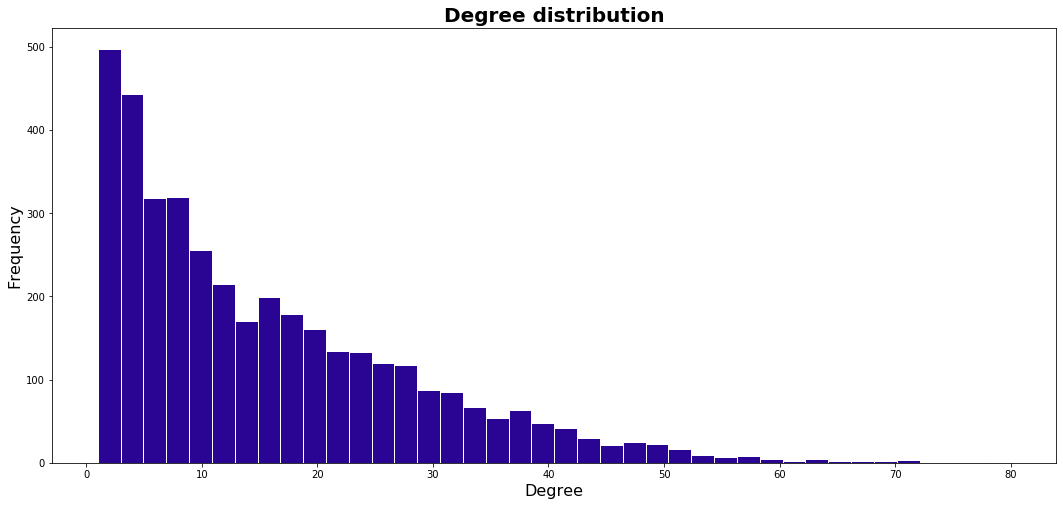

In [80]:
hist_degree, bins_degree = np.histogram(degree_sequence, bins=40) # Returns two arrays
plt.figure(figsize=(18, 8))
bin_midpoints_degree = bins_degree[:-1] + np.diff(bins_degree) / 2
plt.bar(bin_midpoints_degree, hist_degree, width=np.diff(bins_degree), color = colorpalette[1], edgecolor="white", linewidth=1)
plt.xlabel("Degree", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Degree distribution", fontsize=20, fontweight="bold")
plt.show()

In [82]:
# df_largest_cc = df_largest_cc.drop(columns='Degree')
df_degree_sequence = pd.DataFrame(list(G_largest_cc.degree()), columns=['Title', 'Degree'])
df_largest_cc_with_degrees = df_largest_cc.merge(df_degree_sequence, on='Title')

# For genre
average_degree_by_genre = df_largest_cc_with_degrees.groupby('Genre')['Degree'].mean()
sorted_average_degree_by_genre = average_degree_by_genre.sort_values(ascending=False)

# For rating
average_degree_by_rating = df_largest_cc_with_degrees.groupby('RatingLabel')['Degree'].mean()
sorted_average_degree_by_rating = average_degree_by_rating.sort_values(ascending=False)

# Print
print(f'Sorted average degree by genre:\n{sorted_average_degree_by_genre}\n')
print(f'Sorted average degree by rating:\n{sorted_average_degree_by_rating}')

Sorted average degree by genre:
Genre
Action             20.067365
Fantasy            19.094545
Adventure          18.600551
Thriller           16.525000
Mix                16.000000
Comedy             15.788095
Science Fiction    15.725061
Horror              7.613408
Name: Degree, dtype: float64

Sorted average degree by rating:
RatingLabel
High        17.991501
Moderate    16.039618
Low          8.655556
Name: Degree, dtype: float64


From the print above, "Fantasy" movies tend to share actors with more other movies on average. This suggests that the genre tend to have larger casts or that actors in these genres tend to work in more movies within the same genre.

Similarly, the sorted average degree by rating shows that movies with a ‘High’ rating tend to share actors with more other movies on average. This could suggest that highly rated movies tend to have actors who work in more movies, or that actors who work in highly rated movies tend to also work in other highly rated movies.

In [83]:
top_connected_movies = df_degree_sequence.sort_values('Degree', ascending=False)
degree_of_top_10th_connected_movies = top_connected_movies['Degree'].iloc[9]  # Get the degree of the 10th movie
top_10_connected_movies = top_connected_movies[top_connected_movies['Degree'] >= degree_of_top_10th_connected_movies]
top_10_connected_movies

,Title,Degree
3703,The Avengers,80
691,x Xx: Return of Xander Cage,71
679,The Fate of the Furious,71
3503,Into the Woods,71
2931,Gnomeo and Juliet,69
447,The Hitman's Wife's Bodyguard,69
721,Hobbs & Shaw,67
3458,GI Joe: Retaliation,67
1968,Alexander,66
896,Tropic Thunder,65


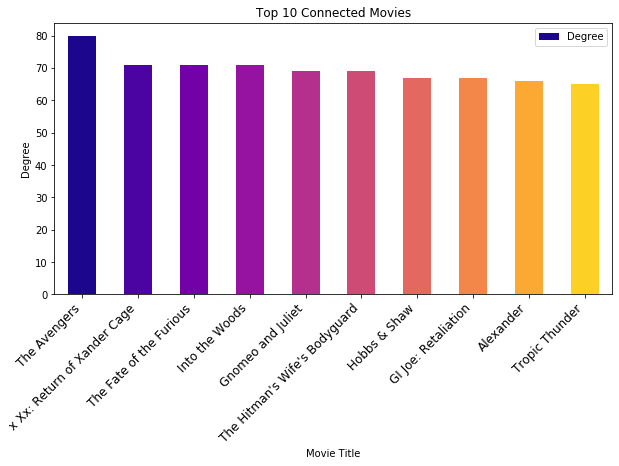

In [84]:
top_10_connected_movies.plot.bar(x="Title", y="Degree", color = colorpalette[::4], figsize=(10, 5))
plt.title("Top 10 Connected Movies")
plt.xlabel("Movie Title")
plt.ylabel("Degree")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()

In [86]:
top_10_movies_details = pd.merge(top_10_connected_movies, df_movies, on='Title', how='left')


In [87]:
print(top_10_movies_details['Genre'].value_counts())

Action             5
Adventure          3
Fantasy            1
Science Fiction    1
Name: Genre, dtype: int64


In [88]:
print(top_10_movies_details['Decade'].value_counts())
# Newer movies are more connected

10-19    7
00-09    2
20-29    1
Name: Decade, dtype: int64


In [89]:
print(top_10_movies_details['RatingLabel'].value_counts())

Moderate    8
High        2
Name: RatingLabel, dtype: int64


In [90]:
print(top_10_movies_details['Director'].unique())

['joss whedon' 'd j caruso' 'f gary gray' 'rob marshall' 'kelly asbury'
 'patrick hughes' 'david leitch' 'jon m chu' 'oliver stone' 'ben stiller']


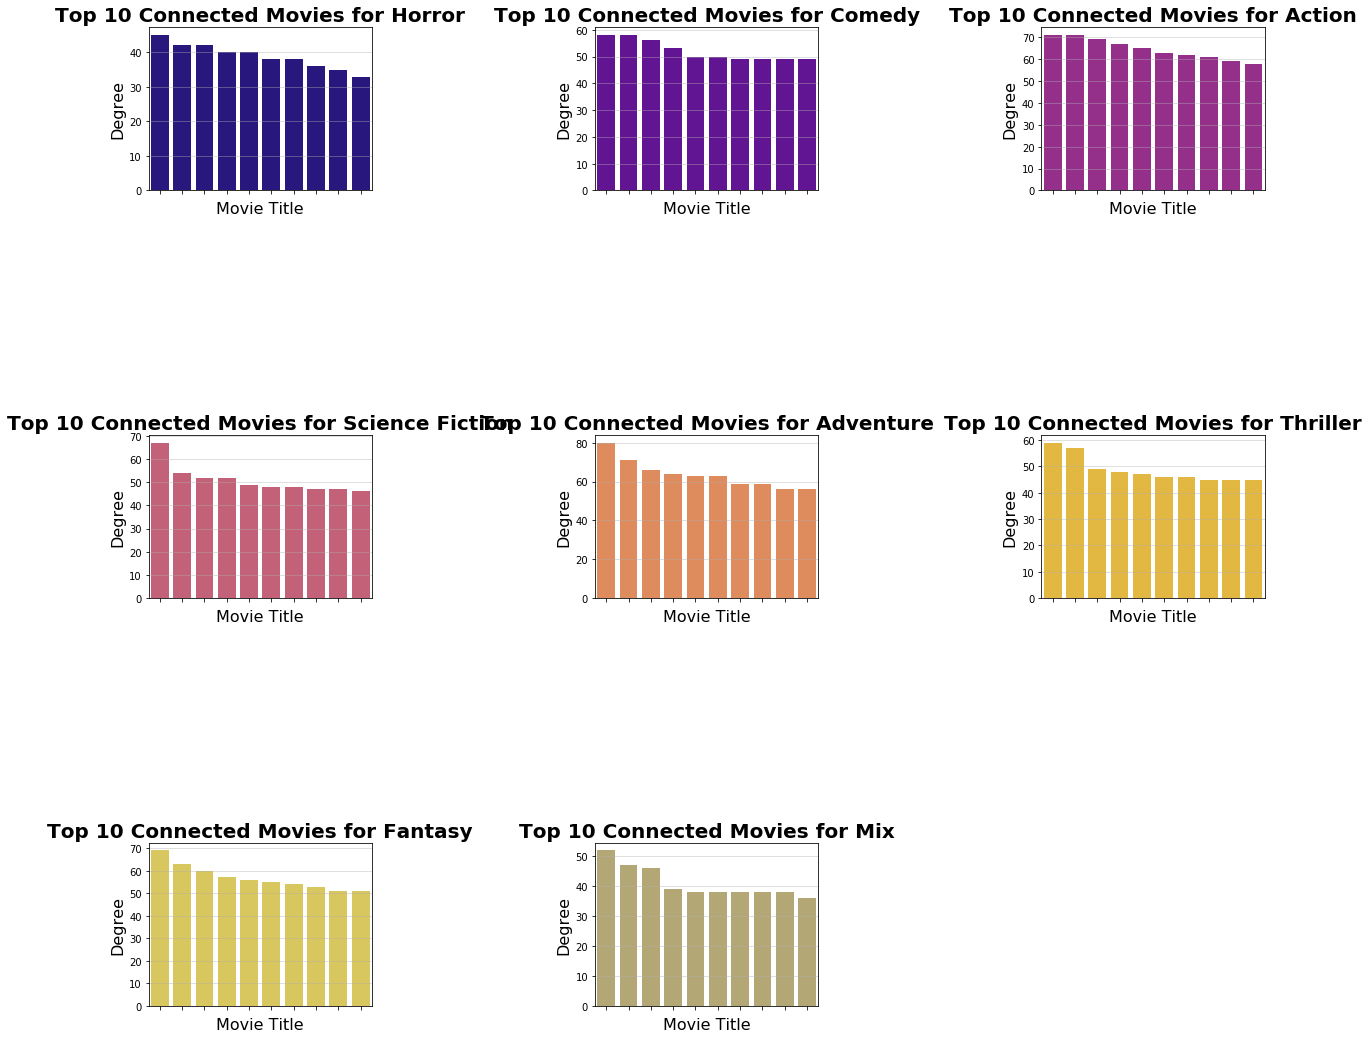

In [91]:
# Make plot for each genre
ordered_genres = df_movies['Genre'].value_counts().index
genre_color_dict = dict(zip(ordered_genres, hex_colors_genre))

# Figure properties
ncolumns = 3
nrows = math.ceil(len(ordered_genres) / ncolumns)
fig, axs = plt.subplots(nrows, ncolumns, figsize=(20, 6*nrows), gridspec_kw={'wspace': 1, 'hspace': 1.5})

for i, genre in enumerate(ordered_genres):
    # Top 10 movies of the genre
    top_movies = df_largest_cc_with_degrees[df_largest_cc_with_degrees["Genre"] == genre].nlargest(10, "Degree")
    
    # Bar plot
    sns.barplot(x="Title", y="Degree", data=top_movies, ax=axs[i//ncolumns, i%ncolumns], color=genre_color_dict[genre])
    axs[i//ncolumns, i%ncolumns].set_title(f"Top 10 Connected Movies for {genre}", fontsize=20, fontweight="bold")
    axs[i//ncolumns, i%ncolumns].set_xticklabels(axs[i//ncolumns, i%ncolumns].get_xticklabels(), rotation=45, ha="right", fontsize=12)
    axs[i//ncolumns, i%ncolumns].set_xlabel("Movie Title", fontsize=16)
    axs[i//ncolumns, i%ncolumns].set_ylabel("Degree", fontsize=16)
    # axs[i//3, i%3].set_xlabel('')
    # axs[i//3, i%3].text(1.2, -0.05, 'Movie Title', verticalalignment='bottom', horizontalalignment='right', transform=axs[i//3, i%3].transAxes)
    axs[i//ncolumns, i%ncolumns].grid(True, linestyle="-", alpha=0.5, axis="y")

# Remove empty subplots
if len(ordered_genres) % ncolumns != 0:
    for j in range(len(ordered_genres) % ncolumns, ncolumns):
        fig.delaxes(axs[nrows-1, j])

plt.tight_layout()
plt.show()

In [92]:
# Degree centrality
degree_centrality = nx.degree_centrality(G_largest_cc)
df_degree_centrality = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['Degree Centrality'])
top_10_movies_degree_centrality = df_degree_centrality.sort_values('Degree Centrality', ascending=False).head(10)
print(top_10_movies_degree_centrality)

                               Degree Centrality
The Avengers                            0.020656
x Xx: Return of Xander Cage             0.018332
The Fate of the Furious                 0.018332
Into the Woods                          0.018332
Gnomeo and Juliet                       0.017816
The Hitman's Wife's Bodyguard           0.017816
Hobbs & Shaw                            0.017299
GI Joe: Retaliation                     0.017299
Alexander                               0.017041
Tropic Thunder                          0.016783


Degree centrality = Number of direct connections a node has in the network.

High degree centrality = many connections to other movies. -> The cast is widely represented across the network.

In [93]:
# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G_largest_cc)
df_eigenvector_centrality = pd.DataFrame.from_dict(eigenvector_centrality, orient='index', columns=['Eigenvector Centrality'])
top_10_movies_eigenvector_centrality = df_eigenvector_centrality.sort_values('Eigenvector Centrality', ascending=False).head(10)
print(top_10_movies_eigenvector_centrality)

                               Eigenvector Centrality
The Fate of the Furious                      0.129846
The Avengers                                 0.124328
x Xx: Return of Xander Cage                  0.120272
Hobbs & Shaw                                 0.115755
Unbreakable                                  0.113464
GI Joe: Retaliation                          0.112490
The Hitman's Wife's Bodyguard                0.110737
The Hitman's Bodyguard                       0.107722
Furious 7                                    0.104107
Fast & Furious 6                             0.104107


Eigenvector centrality = Measure of influence of a node in a network.

High eigenvector centrality = A movie that is connected to other highly connected movies. -> A movie with high eigenvector centrality may not have the most number of common actors, but it is connected to other movies that do. This could suggest that the movie shares actors with a number of influential or popular movies.

## 3.4 Assortativity Analysis

**Objective**

The primary goal of this task is to conduct an Assortativity Analysis of the network. This analysis will offer insights into the connectivity patterns within the network, particularly how they relate to various movie attributes such as rating, genre, and decade.

**Focus on Ratings**

A key focus of this analysis is to explore the relationship between movie ratings and their network connections. Specifically, we aim to investigate if there is a tendency for highly-rated movies to connect with other high-rated movies, while lower-rated films are more inclined to link with movies of similar ratings. This aspect is crucial as actors, who form the links between movies, are hypothesized to significantly influence a movie's success, as reflected in its rating.

By examining the assortativity in the network, we aim to uncover patterns that reveal how actor associations impact movie ratings and success. This understanding is vital for stakeholders in the film industry, including filmmakers and producers, as it can guide strategies for film creation and marketing.

**Validation through Permutation Test**

To ascertain the significance of our findings and determine whether the observed assortativity is not merely due to chance, we will employ a permutation test. This test will help validate whether the assortativity observed in the network is statistically significant, thereby confirming the reliability of our analysis and conclusions.

**Assortativity Coefficient of the Network:**

The degree assortativity coefficient measures the tendency of nodes in the network to connect with other nodes that have a similar degree. In the context of our network, this coefficient help us understand whether movies with similar popularity (inferred from their degree in the network) tend to be connected. This can be particularly insightful for studying patterns and trends in the film industry.

In [134]:
nx.degree_assortativity_coefficient(G_largest_cc)

0.4547848145821132

A value of 0.45 is positive, which means that there exists an assortativity in the network. However, in order to determine whether the observed degree assortativity coefficient is significant or could have occurred by random chance, we will perform permutation test. 

The permutation test will follow the following steps: 
- Shuffling edges while preserving node degrees.
- Compute Assortativity for each permutation. 

In [ ]:
original_coefficient = nx.degree_assortativity_coefficient(G_largest_cc)

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

# Make a copy of the original graph for permutation
G_permuted = G_largest_cc.copy()

for _ in range(n_permutations):
    # Perform edge swaps to shuffle the graph while preserving degree sequence
    G_shuffled = nx.double_edge_swap(G_permuted, nswap=10*len(G_permuted.edges()), max_tries=50*len(G_permuted.edges()))

    # Calculate degree assortativity coefficient for the shuffled graph
    coeff = nx.degree_assortativity_coefficient(G_shuffled)
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = (np.sum([coeff >= original_coefficient for coeff in permuted_coefficients]) + 1) / (n_permutations + 1)

if p_value <= 0.05:
    print(f"The assortativity coefficient for the network is significantly higher than a random group of the same degree size (p-value: {p_value:.4f})")
else:
    print(f"There is no significant difference in assortativity coefficient between the network and a random group of the same size (p-value: {p_value:.4f})")



A degree assortativity coefficient of 0.45, with a significant difference provides some key insights:

A coefficient of 0.45 is a positive value, indicating a tendency towards assortative mixing in our network. This means that nodes (movies) tend to connect with other nodes that have a similar degree. This might suggest that movies with similar levels of popularity as indicated by their number of connections in the network are more likely to be connected to each other. While a coefficient of 0.45 is not extremely high, it still represents a moderately strong degree of assortative mixing.

The fact that the difference is significant implies that this assortative pattern is not due to random chance. Statistical significance in this context means that the observed assortativity is likely a characteristic feature of the network's structure and not an artifact of random variability.

**Assortativity Coefficient of the Network in relation to the attribute *RatingLabel***

This will futher analysis whether the assortativity in the network is connected to the rating. 

In [135]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'RatingLabel')

0.07519845893186923

Once again, we have a positive number which suggests that there exists a assortativity in the network in relation to the rating, however, we will once again perform a permutation test, where we this time shuffle the rating labels randomly. 

In [136]:
original_coefficient = nx.attribute_assortativity_coefficient(G_largest_cc, 'RatingLabel')

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

for _ in range(n_permutations):
    # Shuffle the Rating attribute among nodes
    G_permu = G_largest_cc.copy()
    genres = [G_permu.nodes[n]['RatingLabel'] for n in G_permu.nodes()]
    np.random.shuffle(genres)
    
    # Assign the shuffled genres back to the nodes
    for n, genre in zip(G_permu.nodes(), genres):
        G_permu.nodes[n]['RatingLabel'] = genre
    
    # Calculate assortativity coefficient for the permuted graph
    coeff = nx.attribute_assortativity_coefficient(G_permu, 'RatingLabel')
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = sum(1 for coeff in permuted_coefficients if coeff >= original_coefficient) / n_permutations

print(f"Original Coefficient: {original_coefficient}")
print(f"P-Value: {p_value}")

if p_value <= 0.05:
    print(f"The assortativity coefficient for the network is significantly higher than a random group of the same degree size (p-value: {p_value:.4f})")
else:
    print(f"There is no significant difference in assortativity coefficient between the network and a random group of the same size (p-value: {p_value:.4f})")


Original Coefficient: 0.07519845893186923
P-Value: 0.0
The assortativity coefficient for the network is significantly higher than a random group of the same degree size (p-value: 0.0000)


The assortativity coefficient of 0.0751 combined with a significant result from the permutation test, suggests a weak but statistically significant level of assortative mixing in our network based on the *RatingLabel* attribute. This indicates that there is a slight tendency for nodes (movies) to connect with others that have a similar *RatingLabel*, but this tendency is not very strong. The significance of the result implies that this pattern is not due to random chance, but it is also not a dominant feature of the network's structure.

**Assortativity Coefficient of the Network in relation to the attribute *Genre***

This will futher analyse whether the assortativity in the network is connected to the genre. 

In [137]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'Genre')

0.14321472522608755

In [41]:
original_coefficient = nx.attribute_assortativity_coefficient(G_largest_cc, 'Genre')

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

for _ in range(n_permutations):
    # Shuffle the Genre attribute among nodes
    G_permu = G_largest_cc.copy()
    genres = [G_permu.nodes[n]['Genre'] for n in G_permu.nodes()]
    np.random.shuffle(genres)
    
    # Assign the shuffled genres back to the nodes
    for n, genre in zip(G_permu.nodes(), genres):
        G_permu.nodes[n]['Genre'] = genre
    
    # Calculate assortativity coefficient for the permuted graph
    coeff = nx.attribute_assortativity_coefficient(G_permu, 'Genre')
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = sum(1 for coeff in permuted_coefficients if coeff >= original_coefficient) / n_permutations

print(f"Original Coefficient: {original_coefficient}")
print(f"P-Value: {p_value}")

if p_value <= 0.05:
    print(f"The assortativity coefficient for the network is significantly higher than a random group of the same degree size (p-value: {p_value:.4f})")
else:
    print(f"There is no significant difference in assortativity coefficient between the network and a random group of the same size (p-value: {p_value:.4f})")


Original Coefficient: 0.1432147252260875
P-Value: 0.0
The assortativity coefficient for the network is significantly higher than a random group of the same degree size (p-value: 0.0000)


The attribute assortativity coefficient of 0.143 for the genre attribute in our network and a significant result from the permutation test, indicates a statistically significant level of assortative mixing based on genre. This suggests that movies in our network show a tendency to connect with other movies of the same or similar genres more than would be expected by chance, although this tendency is not particularly strong. This finding, being significant, confirms that the observed pattern is not random and is a characteristic of the network's structure.

## 3.5 Community Analysis

The objective with this task is use find communities in the network using the Louvain algorithm, which is an approximation algorithm that tries to maximize the modularity score. The purpose of community analysis is to identifying subgroups or clusters within the network. These communities can represent groups of movies that are similar in certain aspects, such as genre, actors, directors, or even more interesting ratings. It allows for the examination of collaboration patterns within the film industry. By analyzing how different communities are interconnected, we can gain insights into how collaborations or connections might influence a movie's success. Communities can highlight how certain attributes (like a specific actor or director) spread and influence other movies within the same community. This can be crucial in understanding trends and preferences in the film industry. By identifying communities, we can understand if success is linked to being part of a particular group. Community analysis might reveal that successful movies often emerge from specific collaborative networks, suggesting that the network of professionals (actors, directors, etc.) a movie is associated with can play a significant role in its success. If communities are formed based on genres or themes, we can investigate whether certain genres are more successful than others. This could help in identifying market trends and audience preferences. If communities are not strictly genre-based, it might reveal interesting cross-genre collaborations that lead to successful movies. This can shed light on innovative or unique collaboration patterns that resonate well with audiences.

In [45]:
# Computing best community partition
partition = community.best_partition(G_largest_cc, random_state=42)

# Get a set of the communities
communities = set(partition.values())

# Number of communities (+1 because community "0" also exist)
print('Number of communities:', max(partition.values())+1)

Number of communities: 32


In [46]:
modularity = community.modularity(partition, G_largest_cc)
print('Modularity of Network:', round(modularity,2))

Modularity of Network: 0.57


<ipython-input-172-7edd635cba59>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=x, y=y, data=data, order=order, palette=color_palette)
<ipython-input-172-7edd635cba59>:9: UserWarning: The palette list has more values (40) than needed (32), which may not be intended.
  barplot = sns.barplot(x=x, y=y, data=data, order=order, palette=color_palette)


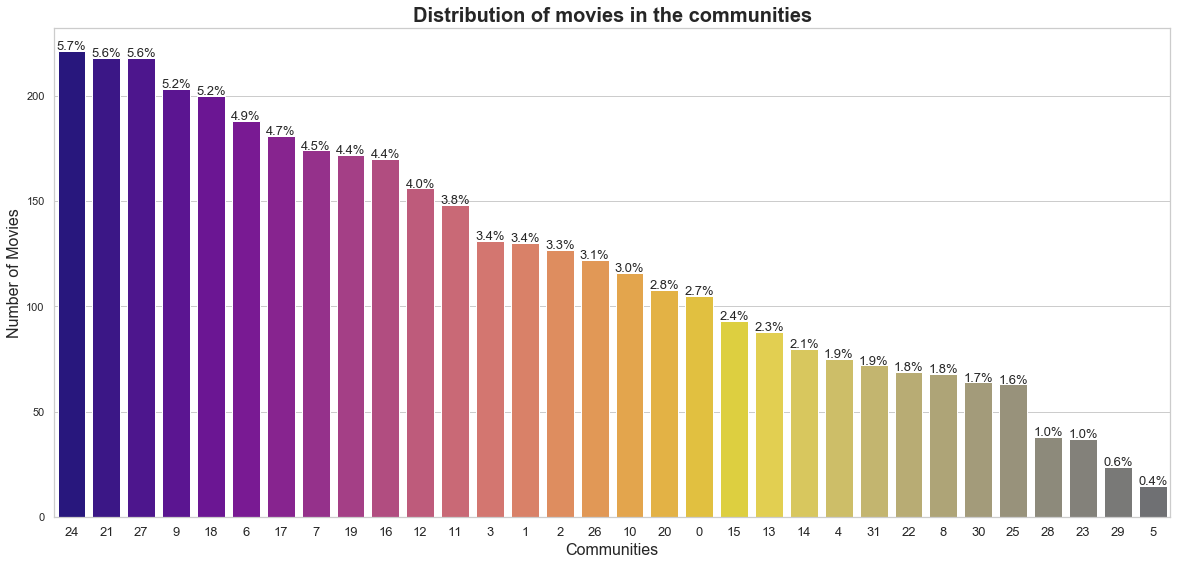

In [176]:
community_count = pd.DataFrame(data={'Communities':list(partition.values())}).value_counts()
community_count = community_count.reset_index()
community_count.columns = ['Communities', 'Count'] 
community_count = community_count.sort_values(by='Count', ascending=False)
ordered = community_count['Communities'].unique()

plots = Plots()
plots.plot_bar(x ='Communities', y='Count', data=community_count, order = ordered, title='Distribution of movies in the communities', 
         xlabel='Communities', ylabel = 'Number of Movies', figsize=(20,9), color_palette=colorpalette[::2])


The algorithm successfully identified 32 distinct communities within the network, achieving a modularity score of 0.57. This score reflects a significant degree of structure within the network, indicating that the communities are well-defined and distinct from each other in terms of their interconnectedness and shared attributes.

Additionally, analysis of the distribution of movies across these communities reveals a notable variance in community sizes. It is observed from the provided plot that certain communities comprise a minimal proportion of the total movies in the dataset, with some containing less than 2% of the overall movie count. This disparity in community sizes suggests a heterogeneous distribution of movies, pointing towards diverse clustering patterns within the network.

**Name the different communities:**

In the following, each community will be named after the three most connected movies in each community. This will make interpretation of the communities much easier. 


In [48]:
# Add community to the dataframe 
title_to_community = pd.Series(partition)
mask = df_largest_cc['Title'].isin(title_to_community.index)
df_largest_cc.loc[mask, 'community'] = df_largest_cc.loc[mask, 'Title'].map(title_to_community)

In [51]:
# Find largest degree nodes in each com.
communities_dict = {c: [k for k, v in partition.items() if v == c] for c in communities}
highest_degree = {k: heapq.nlargest(3, v, key=lambda x: G_largest_cc.degree(x)) for k, v in communities_dict.items()}

# Add column to community dataframe with community names
for key, values in highest_degree.items():
    df_largest_cc.loc[df_largest_cc.community == key, 'com_name'] = ", ".join(values).replace('_',' ') 

In [183]:
name_com = df_largest_cc['com_name'].value_counts()
name_com = name_com.reset_index()
name_com.columns = ['Community Name', 'Count']
print(tabulate(name_com, headers='keys', tablefmt='pretty'))

+----+-------------------------------------------------------------------------------------------------+-------+
|    |                                         Community Name                                          | Count |
+----+-------------------------------------------------------------------------------------------------+-------+
| 0  |                                Blood Rayne, Hellblazers, Samson                                 |  221  |
| 1  |               SPL II: A Time for Consequences, Raging Fire, Ip Man 4: The Finale                |  218  |
| 2  |                     Wrath of the Titans, Clash of the Titans, Batman Begins                     |  218  |
| 3  |            Tropic Thunder, Night at the Museum: Battle of the Smithsonian, Zoolander            |  203  |
| 4  |                    The Prestige, Avengers: Age of Ultron, Avengers: Endgame                     |  200  |
| 5  |                           The Lost City, Knocked Up, This Is the End                     

**Community partition analysis of ratings**

First, we would like to analyse the rating distribution across the communities in order to identify whether some communities are more dominated by a certain rating category. 

In [185]:
rating_counts = df_largest_cc.groupby('com_name')['RatingLabel'].value_counts().unstack(fill_value=0)
rating_counts_reset = rating_counts.reset_index()
print(tabulate(rating_counts_reset, headers='keys', tablefmt='pretty'))

+----+-------------------------------------------------------------------------------------------------+------+-----+----------+
|    |                                            com_name                                             | High | Low | Moderate |
+----+-------------------------------------------------------------------------------------------------+------+-----+----------+
| 0  |                                   Alexander, Epic, Daredevil                                    |  63  |  6  |    61    |
| 1  |                                Blood Rayne, Hellblazers, Samson                                 |  29  | 105 |    87    |
| 2  |                 Constantine, John Wick: Chapter 3 Parabellum, A Scanner Darkly                  |  24  | 12  |    36    |
| 3  |                       Dark Reel, Alien vs Predator, Hellraiser: Hellworld                       |  5   | 18  |    15    |
| 4  |                             Due Date, Stealth, Kiss Kiss Bang Bang                        

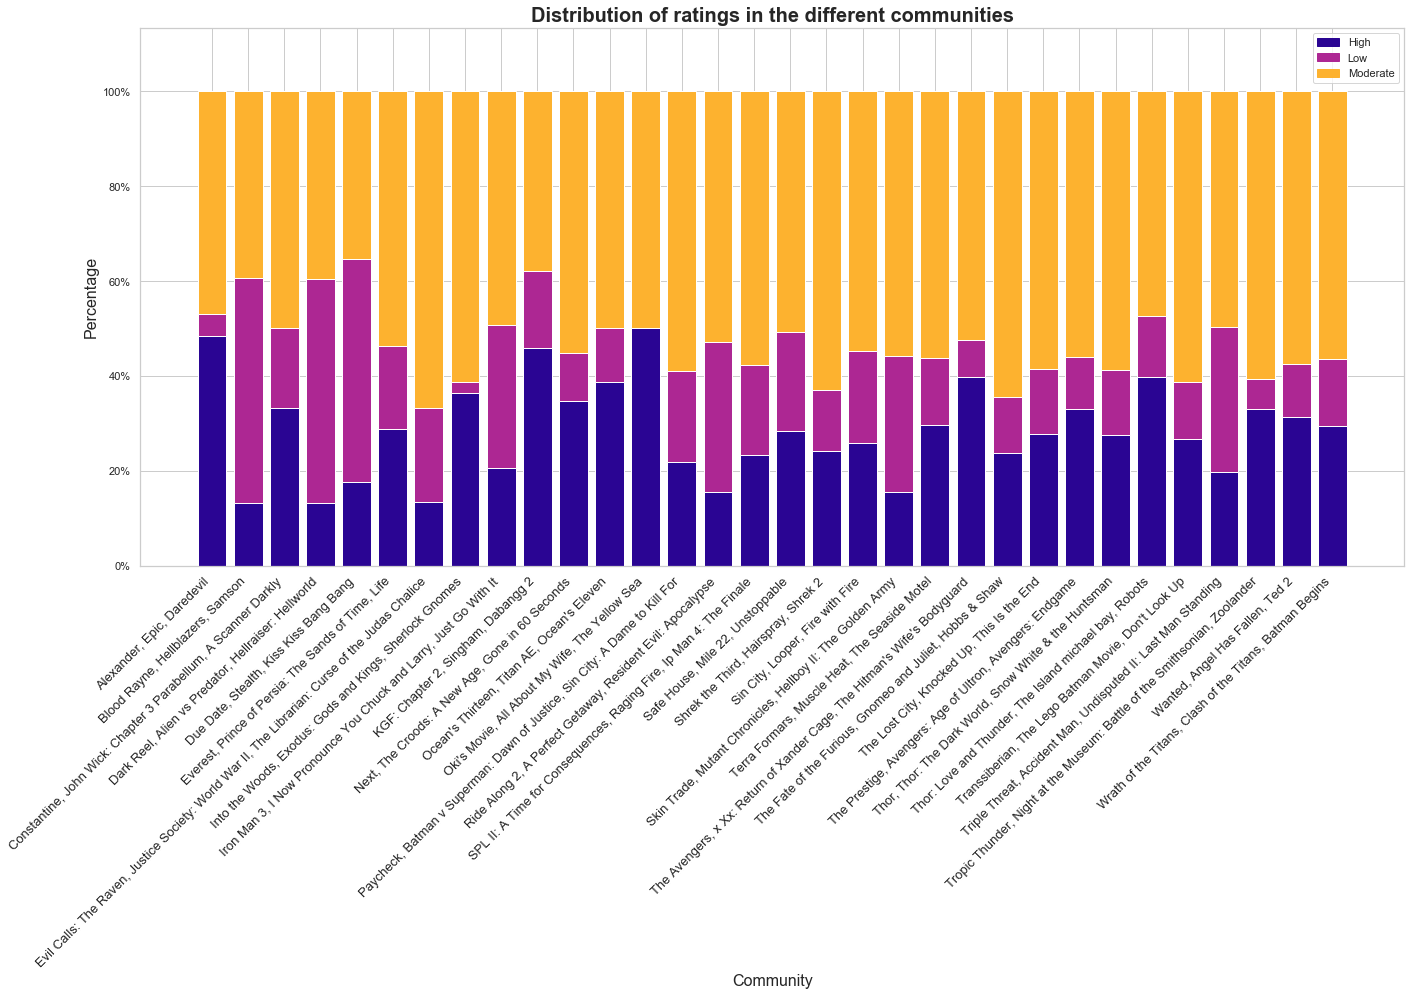

In [191]:
ratings = ['High', 'Low', 'Moderate']
plots.stacked_bar_plot(ratings, rating_counts_reset, 'com_name', three_ratings_colors, 'Distribution of ratings in the different communities', (20, 14))


The analysis of the network plot distinctly reveals that certain communities show a predominant presence of movies from specific rating categories. Notably, the communities *Alexander, Epic, Daredevil*, *Into the Woods, Exodus: Gods and Kings, Sherlock Gnomes*, *The Avengers, x Xx: Return of Xander Cage, The Hitman's Wife's Bodyguard*, *Oki's Movie, All About My Wife, The Yellow Sea*, *Wanted, Angel Has Fallen, Ted 2*, *Tropic Thunder, Night at the Museum: Battle of the Smithsonian, Zoolander*, and *Transsiberian, The Lego Batman Movie, Don't Look Up* predominantly comprise films with high and moderate ratings, with only a minimal presence of low-rated movies. 

Conversely, other communities such as *Blood Rayne, Hellblazers, Samson*, *Dark Reel, Alien vs Predator, Hellraiser: Hellworld* and *Due Date, Stealth, Kiss Kiss Bang Bang* are characterized more by their abundance of low-rated movies than high-rated ones.

While the distinction between low and high-rated movies within these communities is relatively stark, it is notably more challenging to discern a clear pattern for movies with moderate ratings. This lack of distinctiveness in the moderate category is not entirely unexpected, considering it serves as an intermediate classification, encompassing a broad spectrum of ratings. This observation underscores the nuanced nature of movie ratings and their distribution across different communities within the network.

Now let us consider where the top 100 rated and lowest 100 rated movies are in the communities

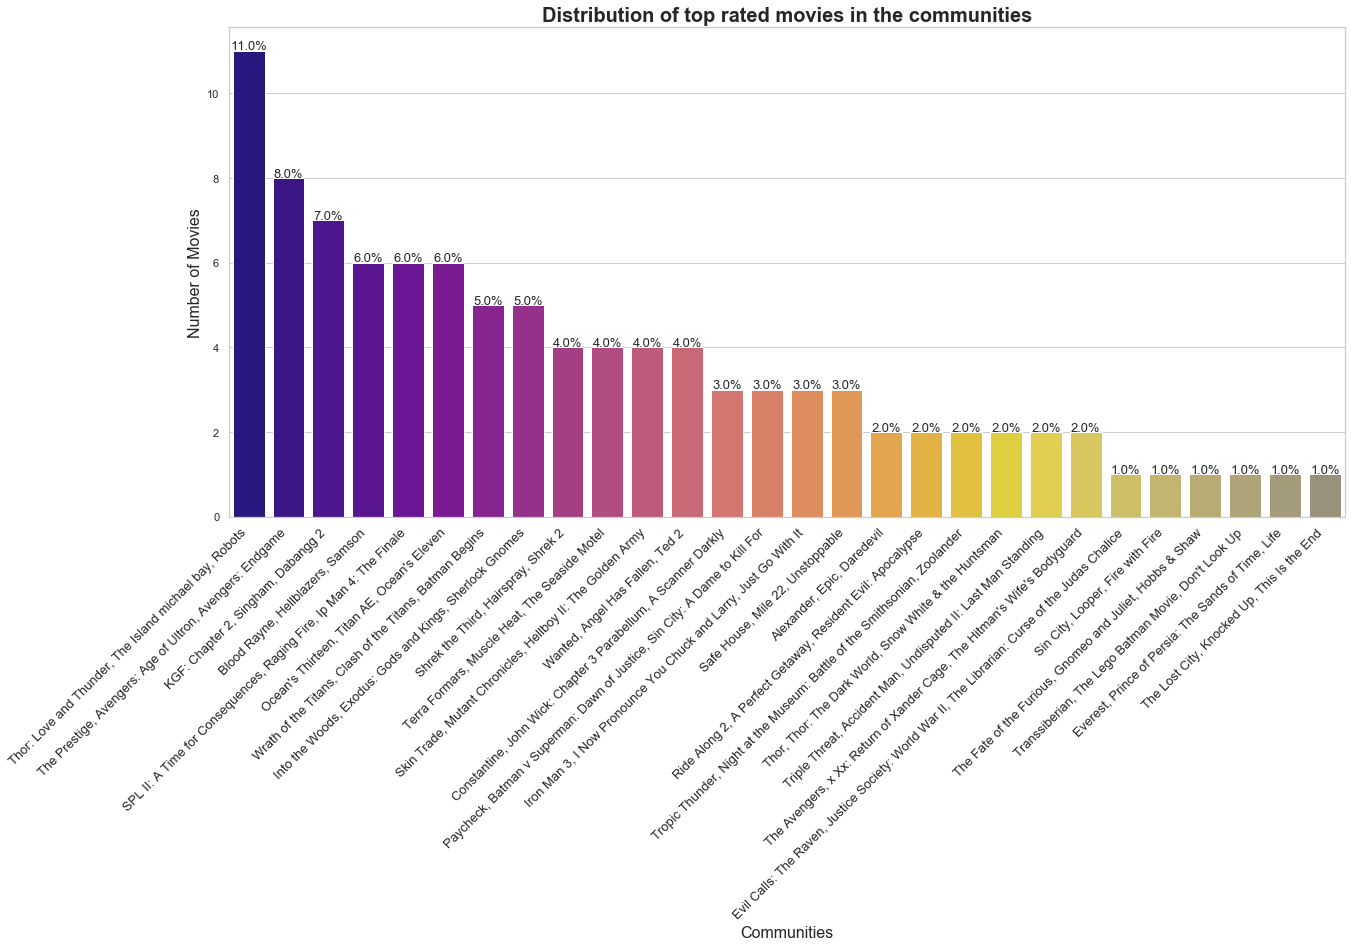

In [207]:
top_rating = df_largest_cc.nlargest(100, 'Rating')['com_name'].value_counts()
top_rating = top_rating.reset_index()
top_rating.columns = ['Rating', 'Count']
data_sorted = top_rating.sort_values(by='Count', ascending=False)
ordered_x = data_sorted['Rating'].unique()
plots = Plots()
plots.plot_bar(x ='Rating', y='Count', data=data_sorted, order=ordered_x, title='Distribution of top rated movies in the communities', 
         xlabel='Communities', ylabel = 'Number of Movies', figsize=(20,9), color_palette=colorpalette[::2], rotation=True)

The data clearly indicates that a significant proportion of the top 100 rated movies are predominantly clustered within the communities of *Thor: Love and Thunder, The Island michael bay, Robots*, *The Prestige, Avengers: Age of Ultron, Avengers: Endgame* and *KGF: Chapter 2, Singham, Dabangg 2*. This concentration suggests that these particular communities possess characteristics or attributes that are associated with higher movie ratings.


In contrast, it is noteworthy that 12 other identified communities contain less than 2% of the top 100 rated movies. This underscores a substantial distributional difference in the network, indicating that the majority of highly rated movies are not evenly dispersed across all communities but are instead concentrated in specific groups. This observation is essential for understanding the dynamics of movie ratings within the network and could offer valuable insights into the factors that contribute to a movie's critical success.

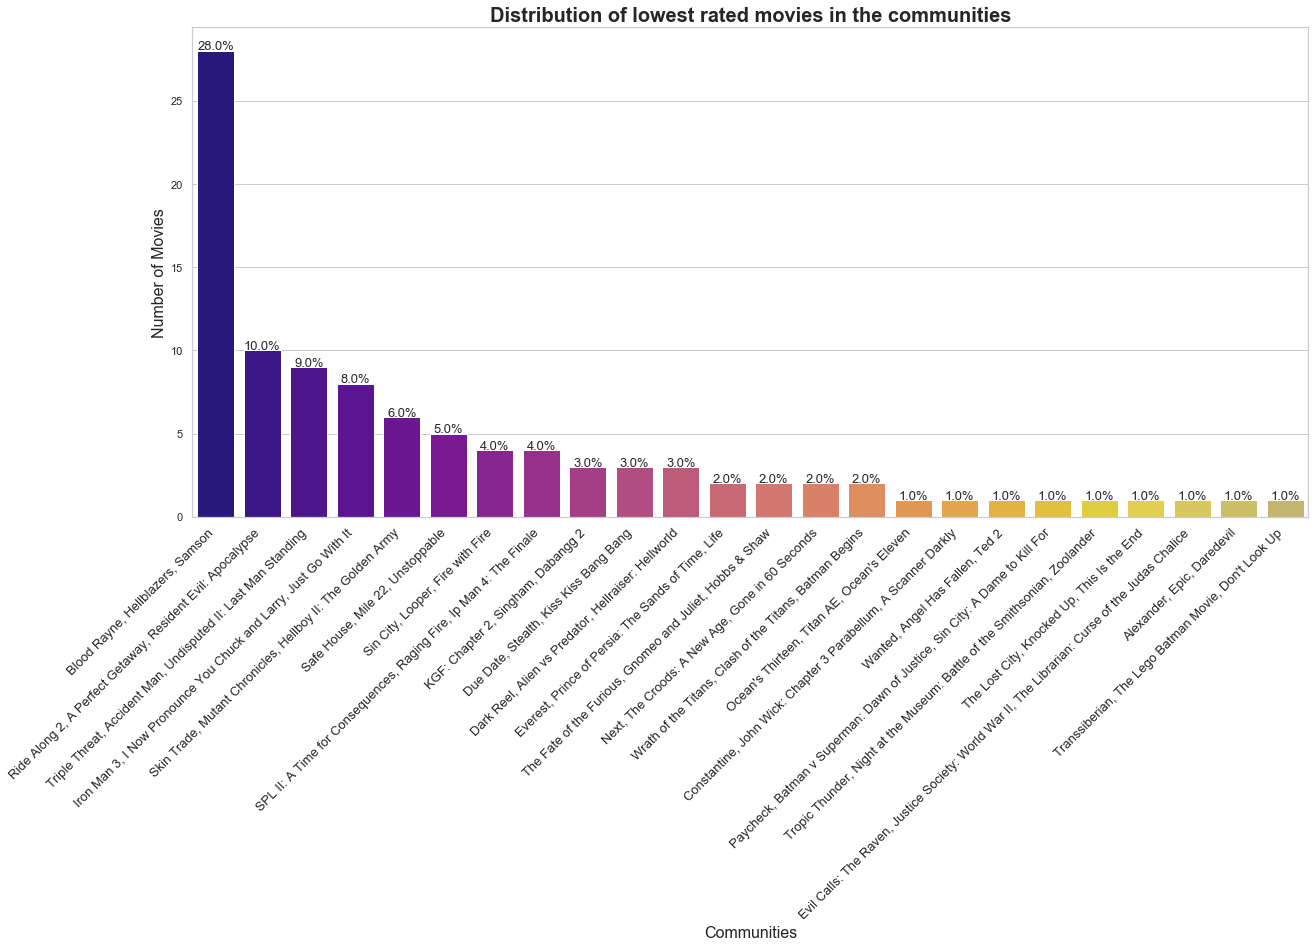

In [208]:
lowest_rating = df_largest_cc.nsmallest(100, 'Rating')['com_name'].value_counts()
lowest_rating = lowest_rating.reset_index()
lowest_rating.columns = ['Rating', 'Count']
data_sorted = lowest_rating.sort_values(by='Count', ascending=False)
ordered_x = data_sorted['Rating'].unique()
plots = Plots()
plots.plot_bar(x ='Rating', y='Count', data=data_sorted, order=ordered_x, title='Distribution of lowest rated movies in the communities', 
         xlabel='Communities', ylabel = 'Number of Movies', figsize=(20,9), color_palette=colorpalette[::2], rotation=True)

It is evident from the plot that a substantial 28% of the 100 lowest rated movies are concentrated within the community represented by *Blood Rayne, Hellblazers, Samson*. This significant clustering of low-rated movies within a single community is a key observation.

In contrast, there are 13 other communities where less than 2% of the movies are among the lowest rated. This distribution indicates a pronounced disparity within the network, where certain communities are markedly associated with lower-rated movies, while others contain only few.

This pattern underlines the earlier conclusion that the communities identified within the network reflect the success, or lack thereof, of the movies they encompass. 

**Community partition analysis of genre**

Now we would like to investigate whether the found communities are dominated by certain genres

In [209]:
genre_counts = df_largest_cc.groupby('com_name')['Genre'].value_counts().unstack(fill_value=0)
genre_counts_reset = genre_counts.reset_index()
print(tabulate(genre_counts_reset, headers='keys', tablefmt='pretty'))

+----+-------------------------------------------------------------------------------------------------+--------+-----------+--------+---------+--------+-----+-----------------+----------+
|    |                                            com_name                                             | Action | Adventure | Comedy | Fantasy | Horror | Mix | Science Fiction | Thriller |
+----+-------------------------------------------------------------------------------------------------+--------+-----------+--------+---------+--------+-----+-----------------+----------+
| 0  |                                   Alexander, Epic, Daredevil                                    |   13   |    21     |   20   |   11    |   27   |  2  |       17        |    19    |
| 1  |                                Blood Rayne, Hellblazers, Samson                                 |   17   |    11     |   13   |    5    |  156   |  2  |       12        |    5     |
| 2  |                 Constantine, John Wick: Chapter 

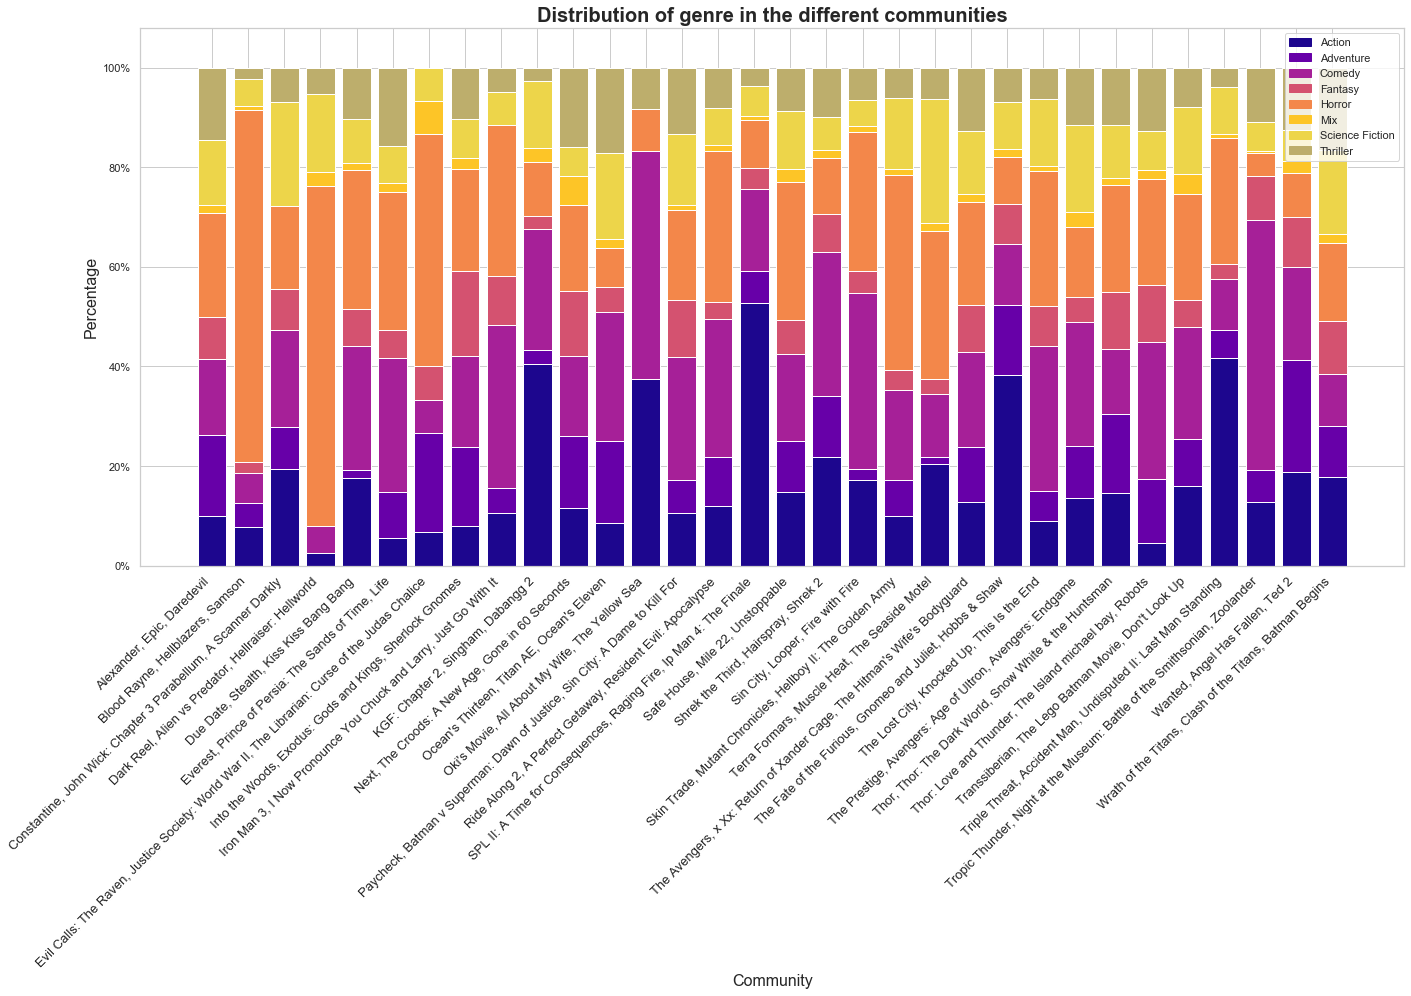

In [212]:
genres = ['Action','Adventure','Comedy','Fantasy','Horror','Mix','Science Fiction','Thriller']
plots.stacked_bar_plot(genres, genre_counts_reset, 'com_name', genre_colors, 'Distribution of genre in the different communities', (20, 14))


The plot provides a clear illustration of how specific genres dominate certain communities within the network. For example, the communities represented by  *Blood Rayne, Hellblazers, Samson* and *Dark Reel, Alien vs Predator, Hellraiser: Hellworld* are predominantly composed of horror movies. This dominance of the horror genre in these communities is a significant observation, indicating a strong genre-based clustering within the network.

Conversely, communities such as *Oki's Movie, All About My Wife, The Yellow Sea* and *Tropic Thunder, Night at the Museum: Battle of the Smithsonian, Zoolander* are primarily characterized by a high concentration of comedy movies. This points to a distinct genre preference within these groups.

Additionally, the communities *KGF: Chapter 2, Singham, Dabangg 2*, *Oki's Movie, All About My Wife, The Yellow Sea*, *SPL II: A Time for Consequences, Raging Fire, Ip Man 4: The Finale* and *The Fate of the Furious, Gnomeo and Juliet, Hobbs & Shaw* and *Triple Threat, Accident Man, Undisputed II: Last Man Standing* are observed to be largely dominated by action movies. This prevalence of the action genre in multiple communities further highlights the tendency of similar genres to cluster together within the network.

This genre-specific clustering within communities is an essential aspect of the network’s structure, providing insights into how movies of similar genres tend to group together, potentially influencing the network dynamics and the movies' success.

**Community partition analysis of Casts**

Exploring the most prominent actor in each community can provide valuable insights into how these actors connect movies within different groups. This analysis can also reveal if there's a link between the actors and the success of the movies in these communities. By examining which communities have the highest-rated movies, and identifying the key actors in these communities, we can better understand if and how actors contribute to a movie's success. This approach can help in identifying patterns and trends that influence film success in the industry.

In [213]:
df_largest_cc['Casts'] = df_largest_cc['Cast'].str.split(',')
df_cast_expanded = df_largest_cc.explode('Casts')
df_cast_expanded['Casts'] = df_cast_expanded['Casts'].str.strip()

cast_counts = df_cast_expanded.groupby(['com_name', 'Casts']).size().reset_index(name='count')
# Rank cast members within each community
cast_counts['rank'] = cast_counts.groupby('com_name')['count'].rank(method='first', ascending=False)

# Filter to keep only top 10 casts in each community
top_casts = cast_counts[cast_counts['rank'] <= 10]

# Pivot the table
pivot_table = top_casts.pivot(index='com_name', columns='rank', values=['Casts', 'count'])

# Flatten the multi-level column headers
pivot_table.columns = [' '.join(map(str, col)).strip() for col in pivot_table.columns.values]
for i in range(1, 11):  # Adjust the range according to the number of top casts you have
    cast_col = f"Casts {float(i)}"
    count_col = f"count {float(i)}"

    if cast_col in pivot_table.columns and count_col in pivot_table.columns:
        pivot_table[cast_col] = pivot_table[cast_col].astype(str) + ", " + pivot_table[count_col].astype(str)
        pivot_table.drop([count_col], axis=1, inplace=True)

pivot_table_reset = pivot_table.reset_index()
# Print the table
print(tabulate(pivot_table_reset, headers='keys', tablefmt='pretty'))


+----+-------------------------------------------------------------------------------------------------+------------------------+-----------------------+-----------------------+---------------------------+-------------------------+--------------------------+----------------------------+----------------------+--------------------------+-------------------------+
|    |                                            com_name                                             |       Casts 1.0        |       Casts 2.0       |       Casts 3.0       |         Casts 4.0         |        Casts 5.0        |        Casts 6.0         |         Casts 7.0          |      Casts 8.0       |        Casts 9.0         |       Casts 10.0        |
+----+-------------------------------------------------------------------------------------------------+------------------------+-----------------------+-----------------------+---------------------------+-------------------------+--------------------------+--------------

/Users/jasmink.j.thari/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


It is clear that the top cast for each community is mostly a well-known actor. 

**Community partition analysis of Directors**

This section of the analysis will focus on identifying the most prominent directors within each community. By examining the currency of specific directors in these groups, we aim to gain insights into whether certain directors are particularly dominant in specific communities. This understanding could be pivotal in interpret the factors that contribute to a movie's success. The presence of dominant directors in certain communities may indicate patterns or trends in filmmaking that are associated with higher levels of success, offering valuable perspectives for the film industry.

In [237]:
director_counts = df_largest_cc.groupby(['com_name', 'Director']).size().reset_index(name='count')
director_counts['rank'] = director_counts.groupby('com_name')['count'].rank(method='first', ascending=False) # Rank Directors members within each community
top_directors = director_counts[director_counts['rank'] <= 3]

pivot_table = top_directors.pivot(index='com_name', columns='rank', values=['Director', 'count']) # Pivot the table

pivot_table.columns = [' '.join(map(str, col)).strip() for col in pivot_table.columns.values]
for i in range(1, 4):
    director_col = f"Director {float(i)}"
    count_col = f"count {float(i)}"

    if director_col in pivot_table.columns and count_col in pivot_table.columns:
        pivot_table[director_col] = pivot_table[director_col].astype(str) + ", " + pivot_table[count_col].astype(str)
        pivot_table.drop([count_col], axis=1, inplace=True)

pivot_table_reset = pivot_table.reset_index()

# Print the table
print(tabulate(pivot_table_reset, headers='keys', tablefmt='pretty'))


+----+-------------------------------------------------------------------------------------------------+-----------------------+-------------------------+---------------------------+
|    |                                            com_name                                             |     Director 1.0      |      Director 2.0       |       Director 3.0        |
+----+-------------------------------------------------------------------------------------------------+-----------------------+-------------------------+---------------------------+
| 0  |                                   Alexander, Epic, Daredevil                                    |  steven spielberg, 5  | anders thomas jensen, 2 |      daniel stamm, 2      |
| 1  |                                Blood Rayne, Hellblazers, Samson                                 |     rob zombie, 7     |    michael feifer, 5    |      claudio fah, 3       |
| 2  |                 Constantine, John Wick: Chapter 3 Parabellum, A Scanner Darkly

**Community partition analysis of Country**
In this part we would investigate whether a specific country or region predominate certain communities. This would provide a broader insight in the collobration between the artists worldwide. 

In [221]:
country_counts = df_largest_cc.groupby('com_name')['Country'].value_counts().unstack(fill_value=0)
country_counts_reset = country_counts.reset_index()
print(tabulate(country_counts_reset, headers='keys', tablefmt='pretty'))

+----+-------------------------------------------------------------------------------------------------+------+-----------+--------+----------------------+-------+-----------------+--------+--------+---------+-----------+-------+-------+-----+---------------+--------+---------------+-------------+-------+----------------+------------------------------+---------------+
|    |                                            com_name                                             | asia | australia | canada | canada united states | china | china hong kong | europe | france | germany | hong kong | india | japan | mix | north nmerica | russia | south america | south korea | spain | united kingdom | united kingdom united states | united states |
+----+-------------------------------------------------------------------------------------------------+------+-----------+--------+----------------------+-------+-----------------+--------+--------+---------+-----------+-------+-------+-----+---------------

First and foremost, it's essential to acknowledge that the majority of movies in the analysis are American, which explains why most communities consist predominantly of films from the USA. However, it's important to note how some communities are primarily composed of movies from other countries. This is particularly evident in communities like *SPL II: A Time for Consequences, Raging Fire, Ip Man 4: The Finale*, which mainly consist of movies from Asian countries such as China and Hong Kong, with a few from the USA. Another community,*KGF: Chapter 2, Singham, Dabangg 2* , exclusively comprises Indian films. Additionally, there's a community, *Oki's Movie, All About My Wife, The Yellow Sea*, which is solely made up of South Korean films. In contrast, the rest of the communities are mostly made up of American films.

# Part 4: Natural Langauage Processing (NLP)

# Functions

In [34]:
class Plots: 
    def plot_bar(self, x, y, data, title, xlabel, ylabel, figsize, color_palette, order=None, rotation=False): 
        # Create the bar plot
        sns.set(style="whitegrid") 
        plt.figure(figsize=figsize) 
        if order is None: 
            barplot = sns.barplot(x=x, y=y, data=data, palette=color_palette[:data[x].shape[0]], hue=x, legend=False)
        else:
            barplot = sns.barplot(x=x, y=y, data=data, order=order, palette=color_palette)


        # Rotate the labels on x-axis for better readability
        if rotation: 
            plt.xticks(rotation=45, ha='right', fontsize=13)
        else: 
            plt.xticks(fontsize=13)
        plt.title(title, fontsize=20, fontweight="bold")
        plt.xlabel(xlabel, fontsize=16)
        plt.ylabel(ylabel, fontsize=16)

        total = sum(p.get_height() for p in barplot.patches)
        for p in barplot.patches:
            percentage = f'{100 * p.get_height() / total:.1f}%'  # Format as a percentage with one decimal
            barplot.annotate(percentage,
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center',
                            xytext=(0, 4),
                            textcoords='offset points',
                            fontsize=13)
        plt.show()

    def stacked_bar_plot(self, list_stacks, df, column, colors, title, figsize):

        # Create a figure and axis for the plot
        fig, ax = plt.subplots(figsize=figsize)

        # Initialize legend handles and labels
        legend_handles = []
        legend_labels = []

        # Iterate through each row in the DataFrame
        for index, row in df.iterrows():
            com_name = row[column]
            
            # Get the rating counts for the current com_name
            counts = [row[count] for count in list_stacks]
            
            # Calculate the total count for normalization
            total_count = sum(counts)
            
            # Convert counts to percentages
            percentages = [count / total_count * 100 for count in counts]
            
            # Create a vertical stacked bar for the current com_name
            bars = ax.bar(com_name, height=percentages, color=colors, bottom=[sum(percentages[:i]) for i in range(len(list_stacks))])
            
            # Create legend handles and labels for each rating
            for i, typ in enumerate(list_stacks):
                if index == 0:
                    legend_handles.append(mpatches.Patch(color=colors[i], label=typ))
            
        # Manually create the legend without count numbers
        ax.legend(handles=legend_handles)

        # Set the y-axis label
        ax.set_ylabel('Percentage', fontsize=16)
        ax.set_xlabel('Community', fontsize=16)

        # Set the y-axis ticks to display percentages
        ax.set_yticklabels(['{:,.0f}%'.format(x) for x in ax.get_yticks()])
        ax.set_ylim([0, ax.get_ylim()[1] * 1.08]) 
        # Rotate the x-axis labels for better readability
        plt.xticks(rotation=45, ha='right',  fontsize=13)

        # Set the plot title
        plt.title(title,  fontsize=20, fontweight='bold')

        # Show the plot
        plt.tight_layout()
        plt.show()

In [ ]:
# Dataframe of artists in communities
df_com=df_largest_cc.copy()

# Horror
set1=set(df_com[df_com.com_name.str.contains('Blood Rayne, Hellblazers, Samson')].Title.values)
set2=set(df_com[df_com.com_name.str.contains('Dark Reel, Alien vs Predator, Hellraiser: Hellworld')].Title.values)

# Action
set3=set(df_com[df_com.com_name.str.contains('SPL II: A Time for Consequences, Raging Fire, Ip Man 4: The Finale')].Title.values)
set4=set(df_com[df_com.com_name.str.contains("KGF: Chapter 2, Singham, Dabangg 2")].Title.values)

# Comedy
set5=set(df_com[df_com.com_name.str.contains('Tropic Thunder, Night at the Museum: Battle of the Smithsonian, Zoolander')].Title.values)

# Subgraphs for the ones we want to show
com1_G=G_largest_cc.subgraph(set1).copy()
com2_G=G_largest_cc.subgraph(set2).copy()
com3_G=G_largest_cc.subgraph(set3).copy()
com4_G=G_largest_cc.subgraph(set4).copy()
com5_G=G_largest_cc.subgraph(set5).copy()



# Combine the sub-graphs to one network (without links between)
c = nx.union(com1_G,com2_G)
c = nx.union(c,com3_G)
c = nx.union(c,com4_G)
c = nx.union(c,com5_G)


net = Network(height='500px', width='100%', bgcolor='white', font_color='black', notebook=True)

# Add nodes from the union network of selected communities
net.from_nx(c)

# Get neighbors
neighbors = net.get_adj_list()

#Adding node atributes
for node in net.nodes:
    node['value'] = len(neighbors[node['id']])               # Size of nodes = degree
    genre = df_largest_cc.loc[df_largest_cc.Title==node['id']]['Genre'].values 
    # Color from genre
    if genre == 'Horror':
        node['color'] = hex_colors_genre[2]
    elif genre == 'Action':
        node['color']= hex_colors_genre[0]
    elif genre == 'Comedy':
        node['color']= hex_colors_genre[4]
    else:
        node['color']=hex_colors_genre[6]
    
    node['label'] = node['label'].replace('_', ' ')         


net.show("Network_genre_communities.html")

In [67]:
# Dataframe of artists in communities
df_com=df_largest_cc.copy()

# Low rating
set1=set(df_com[df_com.com_name.str.contains('Blood Rayne, Hellblazers, Samson')].Title.values)
set2=set(df_com[df_com.com_name.str.contains('Due Date, Stealth, Kiss Kiss Bang Bang')].Title.values)
set3=set(df_com[df_com.com_name.str.contains('Dark Reel, Alien vs Predator, Hellraiser: Hellworld')].Title.values)

# High rating
set4=set(df_com[df_com.com_name.str.contains('Oki\'s Movie, All About My Wife')].Title.values)
set5=set(df_com[df_com.com_name.str.contains("The Avengers, x Xx: Return of Xander Cage, The Hitman's Wife's Bodyguard")].Title.values)
set6=set(df_com[df_com.com_name.str.contains('Alexander, Epic, Daredevil')].Title.values)

# Subgraphs for the ones we want to show
com1_G=G_largest_cc.subgraph(set1).copy()
com2_G=G_largest_cc.subgraph(set2).copy()
com3_G=G_largest_cc.subgraph(set3).copy()
com4_G=G_largest_cc.subgraph(set4).copy()
com5_G=G_largest_cc.subgraph(set5).copy()
com6_G=G_largest_cc.subgraph(set6).copy()


# Combine the sub-graphs to one network (without links between)
c = nx.union(com1_G,com2_G)
c = nx.union(c,com3_G)
c = nx.union(c,com4_G)
c = nx.union(c,com5_G)
c = nx.union(c,com6_G)

net = Network(height='500px', width='100%', bgcolor='white', font_color='black', notebook=True)

# Add nodes from the union network of selected communities
net.from_nx(c)

# Get neighbors
neighbors = net.get_adj_list()

#Adding node atributes
for node in net.nodes:
    node['value'] = len(neighbors[node['id']])               # Size of nodes = degree
    rating = df_largest_cc.loc[df_largest_cc.Title==node['id']]['RatingLabel'].values 
    if rating == 'High':
        node['color'] = three_ratings_colors_hex[2]
    elif rating == 'Low':
        node['color']= three_ratings_colors_hex[0]
    else:
        node['color']=three_ratings_colors_hex[1]
    
    node['label'] = node['label'].replace('_', ' ')         


net.show("Network_rating_communities.html")